# 🏡 **Helping Your Hosts:** Predicting Airbnb Host Ratings 🏨

---

> **Phase 3 Project: Classification**
>
> **Author:** Ben McCarty

---

---

**In a post-COVID world, hospitality faces challenges as travel restrictions are imposed and lifted (and then re-imposed).** Travel and tourism came to a crashing halt in 2020 and still face challenges in returning to pre-2020 business levels.

As restless travelers look to escape the confines of their homes, they expect the same high-quality services and experiences as pre-COVID. Competition within the hospitality industry is stronger than ever, putting more pressure on businesses to keep and grow their customer base.

**The main performance metric for every company involved in hospitality is guest satisfaction.** If a guest isn't satisfied, they are not likely to return for another visit and may share their experience with others, pushing away potential business.

Airbnb hosts face the same challenges as traditional hotels in these aggressive and challenging market conditions. In order to maximize their profitability and to distinguish themselves from traditional hotels, **Airbnb needs to know which aspects of a host property are the strongest predictors of whether a guest will give a satisfaction score of 4.8 or higher (out of 5).**

With this question in mind, I obtained data about Airbnb host properties from the [Inside Airbnb project](http://insideairbnb.com/get-the-data.html#:~:text=Washington%2C%20D.C.%2C%20District%20of%20Columbia%2C%20United%20States) for the Washington, D.C. area. The dataset includes details about the hosts themselves; property details (bedrooms, bathrooms, property types); and reservation availability.

**Once I have the data readied, I will use machine learning modeling techniques to determine my most important features for the region.** Then I will provide my final recommendations on what Airbnb should do to maximize the likelihood of their hosts obtaining a score of 4.8 or greater.

---

# 📂 **Imports and Settings**

In [1]:
## Tools to reload functions
%load_ext autoreload
%autoreload 2

In [2]:
## Data Handling
import pandas as pd
import numpy as np
import datetime

## Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact_manual
import missingno
import shap

## Personal functions
from bmc_functions import eda
from bmc_functions import classification as clf

## Settings
from IPython.display import display
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)

In [3]:
## Speeding up SKLearn via Intel(R) Extension for Scikit-learn*
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
## Scikit-Learn
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTE

## ✅ Show Visualizations Setting

In [5]:
## Setting to control whether or not to show visualizations
show_visualizations = False

# 📖 **Read Data**

In [6]:
## Reading data and saving to a DataFrame

source = 'data/listings.csv.gz'
data = pd.read_csv(source)
data.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20210710190002,2021-07-11,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,https://www.airbnb.com/users/show/4645,Vita,2008-11-26,"Washington D.C., District of Columbia, United ...","I am a literary scholar, teacher, poet, vegan ...",within a day,80%,75%,f,https://a0.muscache.com/im/users/4645/profile_...,https://a0.muscache.com/im/users/4645/profile_...,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Washington, District of Columbia, United States",Historic Anacostia,nan,38.86,-76.99,Private room in house,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,2021-07-11,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,3943,https://www.airbnb.com/rooms/3943,20210710190002,2021-07-11,Historic Rowhouse Near Monuments,Please contact us before booking to make sure ...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/432713/fab7dd...,5059,https://www.airbnb.com/users/show/5059,Vasa,2008-12-12,"Washington, District of Columbia, United States",I have been living and working in DC for the l...,within a few hours,100%,29%,f,https://a0.muscache.com/im/pictures/user/8ec69...,https://a0.muscache.com/im/pictures/user/8ec69...,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Washington, District of Columbia, United States","Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room in townhouse,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,2021-07-11,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,4529,https://www.airbnb.com/rooms/4529,20210710190002,2021-07-11,Bertina's House Part One,This is large private bedroom with plenty of...,Very quiet neighborhood and it is easy accessi...,https://a0.muscache.com/pictures/86072003/6709...,5803,https://www.airbnb.com/users/show/5803,Bertina'S House,2008-12-30,"Washington, District of Columbia, United States","I am an easy going, laid back person who loves...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/5803/profile_...,https://a0.muscache.com/im/users/5803/profile_...,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Washington, District of Columbia, United States","Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room

In [7]:
## Checking number of rows and columns
data.shape

(8033, 74)

---

> The initial read of the dataset shows there are 74 features and 8,033 entries. A quick glance at the `.head()` gives a sample of the entries, showing that some of the features are not relevant to my analysis.
>
> I need to get a better idea of the statistics for the dataset, especially any missing values and the datatypes for each column. I need to pre-process this data before I can perform any modeling.

---

# 👨‍💻 **Interactive Investigation**

---

> To increase accessibility to the data, **I include a widget to allow the user to sort through the data interactively.** I use [**Jupyter Widgets**](https://ipywidgets.readthedocs.io/en/latest/index.html) to create this interactive report.
>
>**To use:** select which column by which you would like to sort from the dropdown menu, then click the "Run Interact" button.
>
>***Note about 'Drop_Cols' and Cols:*** these keyword arguments are used to allow the user to drop specific columns.
>
> **Only click the "Drop_Cols" option when specifying "Cols"!** Otherwise it will cause an error.
>
>The 'Cols' dropdown menu does not affect the resulting report; the data is filtered from the report prior to displaying the results. 
>
>I chose to include this option for flexibility and adaptability, but it does have the unintended consequence of creating another drop-down menu. Please ignore this menu, as it does not provide any additional functionality. For future work, I will disable the menu to prevent confusion.

---

In [8]:
## Running report on unfiltered dataset

interact_manual(eda.sort_report, Sort_by=list(eda.report_df(data).columns),
                Source=source);

interactive(children=(Text(value='data/listings.csv.gz', description='Source'), Dropdown(description='Sort_by'…

---

**Initial Inspection**

> After reviewing my data, I see there are several features that contain irrelevant entries (URLs, source data, meta data) or values that are too complicated for simple processing (such as host and listing descriptions).
>
> I will drop these columns for the second report to review the remaining data for further processing.

---

In [10]:
## Specifying columns to drop

drop = ['id', 'host_id', 'name', 'description', 'neighborhood_overview', 'host_name',
        'host_about', 'host_location', 'neighbourhood', 'property_type',
        'listing_url', 'scrape_id', 'last_scraped', 'picture_url','host_url',
        'host_thumbnail_url','host_picture_url','calendar_last_scraped']

In [134]:
## Dropping irrelevant columns
df = data.drop(columns=drop).copy()
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-11-26,within a day,80%,75%,f,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,nan,38.86,-76.99,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,2008-12-12,within a few hours,100%,29%,f,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,2008-12-30,NaN,NaN,NaN,f,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room,4,nan,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,30,180,30,30,180,180,30.00,180.00,nan,t,29,59,89,179,102,0,0,2014-09-23,2019-07-05,4.66,4.80,4.60,4.93,4.93,4.51,4.83,NaN,f,1,0,1,0,1.23
3,2009-01-26,within a few hours,100%,78%,t,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.91,-76.99,Private room,1,nan,3 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,2,365,2,2,365,365,2.00,365.00,nan,t,0,0,0,146,31,0,0,2012-02-13,2016-09-22,4.74,4.68,4.89,4.93,4.93,4.21,4.64,NaN,f,3,0,3,0,0.27
4,2009-01-13,within a few hours,100%,17%,f,Adams Morgan,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",nan,38.92,-77.04,Entire home/apt,3,nan,1 bath,1.00,1.00,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,5,150,5,23,150,150,8.80,150.00,nan,t,7,32,62,121,95,0,0,2010-07-30,2020-03-05,4.54,4.75,4.17,4.83,4.84,4.91,4.47,NaN,f,2,1,1,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8028,2020-08-03,NaN,NaN,NaN,f,Southeast Washington,0.00,0.00,"['email', 'phone']",t,f,"Congress Heights, Bellevue, Washington Highlands",nan,38.83,-77.00,Entire home/apt,8,nan,1 bath,3.00,3.00,"[""First aid kit"", ""Dedicated workspace"", ""Smok...",$400.00,2,2,2,2,1125,1125,2.00,"1,125.00",nan,t,17,43,73,348,0,0,0,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,t,1,1,0,0,nan
8029,2020-07-29,within an hour,100%,83%,f,East Forest,125.00,125.00,"['email', 'phone']",t,t,"Howard University, Le Droit Park, Cardozo/Shaw",nan,38.92,-77.02,Entire home/apt,5,nan,2 baths,2.00,nan,"[""Cooking basics"", ""Lockbox"", ""Long term stays...",$198.00,90,365,90

In [12]:
## Generating updated interactive report
interact_manual(eda.sort_report, Drop_Cols = True, Cols = drop,
                Sort_by=list(eda.report_df(df).columns), Source=source);

interactive(children=(Text(value='data/listings.csv.gz', description='Source'), Dropdown(description='Sort_by'…

---

**Interpretation:**

> The report shows that the dataset has a big problem with missing values:
>
>* **100% Missing:**
>   * `neighbourhood_group_cleansed`
>   * `bathrooms`
>   * `calendar_updated`
></br></br>
> * **~100% Missing:**
>   * `license`
></br></br>
> * **26-39% Missing:**
>   * `host_about`
>   * `neighborhood_overview`
>   * `neighbourhood`
>   * `host_response_time`
>   * `host_response_rate`
>   * `review_scores_value`
>   * `review_scores_checkin`
>   * `review_scores_location`
>   * `review_scores_accuracy`
>   * `review_scores_communication`
>   * `review_scores_cleanliness`
>   * `host_acceptance_rate`
>   * `reviews_per_month`
>   * `first_review`
>   * `review_scores_rating`
>   * `last_review`

---

## **Handling the Missing Values**

---

> I will need to address these missing values before processing with the modeling. My options include:
>
>
>* **Filling missing values with an imputer as part of modeling pipeline**
>   * *Allows for the flexibility to test different imputation methods*
>   * *Can add a feature to indicate which features were missing values.*</br></br>
>
>* **Dropping the rows with missing values.**
>   * *Reduces the number of features used in modeling, reducing dimensionality*
>   * *May decrease model performance due to less information*</br>

**I will use a mix of these two options:** I will drop the features missing nearly all of the values, then I will use an imputer during my pipeline process in combination with a GridSearch to identify the best method to use to fill the missing values.

---

---

**MissingNo**

> To get a better idea of the missing values, I create a visual of the values via the 'Missingno' package. This visualization package includes several options for visualizing the missing data.
</br></br>
> *Note: please set the "show_visualizations" variable to "True" to show these visualizations. By default they are disabled due to time required for processing.*

---

In [13]:
## Visually inspecting missing values
if show_visualizations == True:
    missingno.bar(data, labels=True);

In [14]:
## Visually inspecting missing values
if show_visualizations == True:
    missingno.matrix(data, labels=True);

---

> Based on this visualization, I see that **there is a consistent trend in missing values for review scores:** if a row is missing one review score, it seems to be missing all of them.
>
> Additionally, **there are many missing values for the response time, response rate, and acceptance rate.** I want to use these columns in my classification, so I will need to replace those missing values.
>
> After reviewing these details, **I feel more comfortable with the option of dropping those rows with missing review values.** I will drop the values as part of my overall classification process.

---

## Data Types

In [133]:
data.dtypes.value_counts(normalize=1)

object    0.46
int64     0.28
float64   0.26
dtype: float64

# 🧼 **Data Cleaning and EDA**

---

**Cleaning Process**

> To begin the cleaning process, I will:
>   * Drop the rows missing values for the target feature
>   * Drop features missing 98-100% of values

**Processing Remaining Missing Values**

> Instead of performing any manual updates to the remaining values, I will test different imputation methods as part of my modeling pipeline. </br></br>
> Potential methods would include:
>   * Imputing the string "MISSING"
>   * Imputing the most frequent value for string values
>   * Using the mean, median, or mode for numeric datatypes
>
> The benefit of including this step in a pipeline is that I will be able to include these different methods in a GridSearchCV as part of my hyperparameter turning steps.

---

## Dropping Rows Without Target Value

---

To start my data cleaning and exploration, I will drop any rows missing values for my target feature.

---

In [15]:
## Calculating number of missing values for target feature
display(df['review_scores_rating'].isna().sum())
f"The target feature is missing {round(df['review_scores_rating'].isna().sum() / len(df)*100, 2)}% of its data."

2207

'The target feature is missing 27.47% of its data.'

In [16]:
## Identifying row indices
nan_index = df['review_scores_rating'].isna()
nan_index

0       False
1       False
2       False
3       False
4       False
        ...  
8028     True
8029     True
8030     True
8031     True
8032     True
Name: review_scores_rating, Length: 8033, dtype: bool

In [17]:
## Dropping rows by index and resetting index
df = df.drop(df[nan_index].index)
df.reset_index(drop=True, inplace=True)
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-11-26,within a day,80%,75%,f,Anacostia,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,nan,38.86,-76.99,Private room,1,nan,1 private bath,1.00,1.00,"[""First aid kit"", ""Long term stays allowed"", ""...",$55.00,2,365,2,2,365,365,2.00,365.00,nan,t,1,31,61,336,75,3,0,2014-06-22,2021-01-12,4.59,4.71,4.44,4.89,4.82,3.80,4.58,NaN,f,2,0,2,0,0.87
1,2008-12-12,within a few hours,100%,29%,f,Eckington,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.00,Private room,2,nan,1.5 shared baths,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Dedicated...",$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",nan,t,9,39,69,344,429,0,0,2010-08-08,2018-08-07,4.82,4.89,4.91,4.94,4.90,4.54,4.74,NaN,f,2,0,2,0,3.22
2,2008-12-30,NaN,NaN,NaN,f,Eastland Gardens,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",nan,38.91,-76.94,Private room,4,nan,1 shared bath,1.00,1.00,"[""Cooking basics"", ""First aid kit"", ""Keypad"", ...",$54.00,30,180,30,30,180,180,30.00,180.00,nan,t,29,59,89,179,102,0,0,2014-09-23,2019-07-05,4.66,4.80,4.60,4.93,4.93,4.51,4.83,NaN,f,1,0,1,0,1.23
3,2009-01-26,within a few hours,100%,78%,t,Ivy City,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",nan,38.91,-76.99,Private room,1,nan,3 baths,1.00,1.00,"[""Cable TV"", ""TV with standard cable"", ""Kitche...",$99.00,2,365,2,2,365,365,2.00,365.00,nan,t,0,0,0,146,31,0,0,2012-02-13,2016-09-22,4.74,4.68,4.89,4.93,4.93,4.21,4.64,NaN,f,3,0,3,0,0.27
4,2009-01-13,within a few hours,100%,17%,f,Adams Morgan,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",nan,38.92,-77.04,Entire home/apt,3,nan,1 bath,1.00,1.00,"[""Window guards"", ""Cooking basics"", ""First aid...",$86.00,5,150,5,23,150,150,8.80,150.00,nan,t,7,32,62,121,95,0,0,2010-07-30,2020-03-05,4.54,4.75,4.17,4.83,4.84,4.91,4.47,NaN,f,2,1,1,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,2014-06-03,within a few hours,100%,75%,f,Northeast Washington,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.92,-77.01,Entire home/apt,3,nan,1 bath,1.00,2.00,"[""HDTV with Amazon Prime Video, Netflix"", ""Fir...",$104.00,2,24,2,3,24,24,2.30,24.00,nan,t,20,50,80,354,1,1,1,2021-07-05,2021-07-05,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,1,0,0,1.00
5822,2012-06-13,within an hour,100%,100%,f,Northwest Washington,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",nan,38.91,-77.01,Entire home/a

In [18]:
## Reviewing results
f"There are {df['review_scores_rating'].isna().sum()} missing values."

'There are 0 missing values.'

---

> Now that I dropped the missing values for my target feature, I will review the distribution of my ratings.

---


In [19]:
## Reviewing the percentage of ratings at or above the threshold of 4.8

f"{round(len(df['review_scores_rating'][df['review_scores_rating'] >= 4.8])/ len(df)*100, 0)} of ratings are at/above the threshold"

'62.0 of ratings are at/above the threshold'

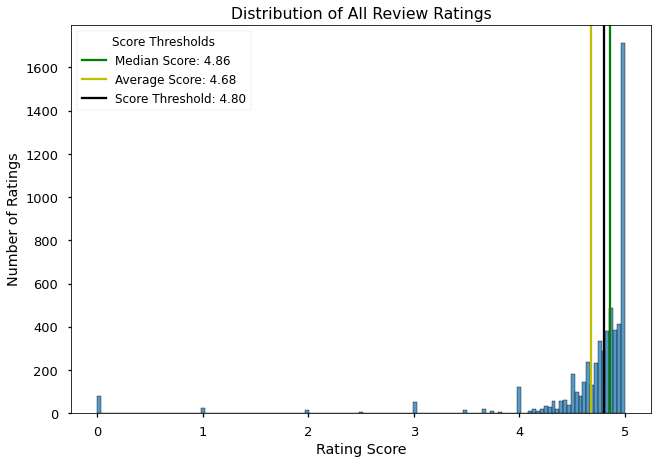

In [20]:
## Visualizing the overall distribution of ratings

ax = sns.histplot(data = df['review_scores_rating'], bins = 'auto')

ax.set(title = 'Distribution of All Review Ratings',
       xlabel = 'Rating Score', ylabel = 'Number of Ratings')

median = df['review_scores_rating'].median()
mean = round(df['review_scores_rating'].mean(), 2)
ax.axvline(median, label = f'Median Score: {median}', color='g')
ax.axvline(mean, label = f'Average Score: {mean}', color='y')
ax.axvline(4.8, label = 'Score Threshold: 4.80', color='k')
ax.legend(fontsize= 'large',title = 'Score Thresholds',
          title_fontsize = 'large');

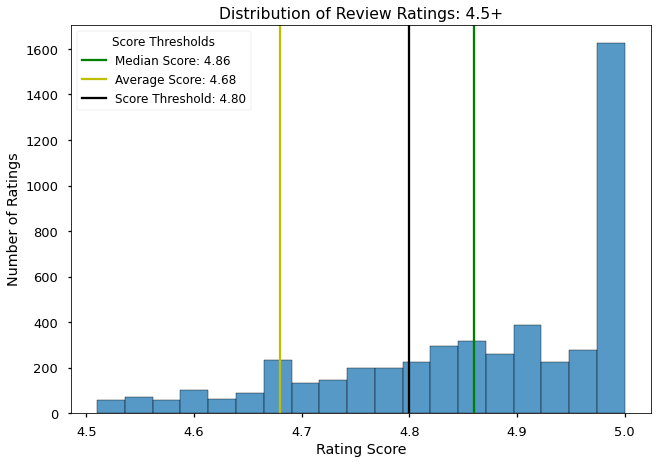

In [21]:
## Zooming in on 4.5 - 5.0 range
ax = sns.histplot(data = df['review_scores_rating'][df['review_scores_rating']>4.5], bins = 'auto')
ax.set(title = 'Distribution of Review Ratings: 4.5+', xlabel = 'Rating Score', ylabel = 'Number of Ratings')
median = df['review_scores_rating'].median()
mean = round(df['review_scores_rating'].mean(), 2)
ax.axvline(median, label = f'Median Score: {median}', color='g')
ax.axvline(mean, label = f'Average Score: {mean}', color='y')
ax.axvline(4.8, label = 'Score Threshold: 4.80', color='k')
ax.legend(fontsize= 'large',title = 'Score Thresholds',title_fontsize = 'large');

---

**Observations and Next Steps**

> Based on the results above, I see that **62% of the reviews are at or above the target threshold of 4.8.**
>
> These scores show that there's a close balance of scores that are meeting our threshold. However, this imbalance may still impair the performance of my future model.
>
> To address this imbalance, I will later use the SMOTE technique to oversample the minority class.

---

# 🔨 Feature Selection and Engineering

---

**Selecting Features to Drop**

> * Dropping:
>    * all features beginning with "review" except target (these review scores constitute the target)
>    * features missing nearly all/all values
>    * `host_is_superhost` - status requires score of 4.8+
>    * `amenities` - string containing listing-specific amenities; removed due to non-standard/varied data adding little extra value to the model
>        * **Future work:** using NLP to identify the most common amenities to create more valuable features
>    * `host_neighborhood` - `neighbourhood_cleansed` is more substantial and covers the same data
>    * `first_review` - does not add significant value
</br></br>

**Engingeering New Features**

>    * `reviewed_within_year`: boolean column representing whether or not the reservation was booked within a year from the specified date

## Dropping Features

In [22]:
## Generating list of columns to drop starting with features beginning with "review_" (except the target feature)
drop_feats = df.loc[:, df.columns.str.startswith('review_')].drop(columns='review_scores_rating').columns.to_list()

## Adding additional features as described above
drop_feats.extend(['host_is_superhost',"amenities", 'host_neighbourhood', 'first_review'])
drop_feats

['review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'host_is_superhost',
 'amenities',
 'host_neighbourhood',
 'first_review']

In [23]:
## Adding column names for features missing more than 90% of their data
drop_feats.extend(df.isna().mean()[df.isna().mean() > .9].index.to_list())
drop_feats

['review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'host_is_superhost',
 'amenities',
 'host_neighbourhood',
 'first_review',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'calendar_updated',
 'license']

In [24]:
## Dropping selected features
df = df.drop(columns=drop_feats)
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,last_review,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-11-26,within a day,80%,75%,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,2021-01-12,4.59,f,2,0,2,0,0.87
1,2008-12-12,within a few hours,100%,29%,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,2018-08-07,4.82,f,2,0,2,0,3.22
2,2008-12-30,NaN,NaN,NaN,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,2019-07-05,4.66,f,1,0,1,0,1.23
3,2009-01-26,within a few hours,100%,78%,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,2016-09-22,4.74,f,3,0,3,0,0.27
4,2009-01-13,within a few hours,100%,17%,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,2020-03-05,4.54,f,2,1,1,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,2014-06-03,within a few hours,100%,75%,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.92,-77.01,Entire home/apt,3,1 bath,1.00,2.00,$104.00,2,24,2,3,24,24,2.30,24.00,t,20,50,80,354,1,1,1,2021-07-05,5.00,f,1,1,0,0,1.00
5822,2012-06-13,within an hour,100%,100%,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.01,Entire home/apt,4,1 bath,1.00,3.00,$96.00,2,14,2,4,14,14,2.00,14.00,t,27,49,78,78,1,1,1,2021-07-05,5.00,f,1,1,0,0,1.00
5823,2011-02-17,within an hour,100%,99%,6.00,6.00,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.93,-77.02,Entire home/apt,8,1.5 baths,3.00,4.00,$236.00,1,1125,1,2,1125,1125,1.30,"1,125.00",t,22,40,70,344,4,4,4,2021-07-06,5.00,t,4,3,1,0,4.00
5824,2019-06-19,within a few hours,88%,100%,0.00,0.00,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",38.96,-77.08,Entire home/apt,3,1 bath,1.00,2.00,$139.00,1,10,1,1,10,10,1.00,10.00,t,20,47,77,352,1,1,1,2021-07-05,5.00,f,1,1,0,0,1.00


## Creating `reviewed_within_year` Feature

In [25]:
## Determining the date a year ago
selected_date = datetime.datetime(2021, 10, 14)
last_year = (selected_date-datetime.timedelta(days=365))
last_year

datetime.datetime(2020, 10, 14, 0, 0)

In [26]:
## Generating boolean feature representing if the last review was within a year of the specified date
df['reviewed_within_year'] = (pd.to_datetime(df['last_review']) >= last_year).astype(int)
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,last_review,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year
0,2008-11-26,within a day,80%,75%,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,2021-01-12,4.59,f,2,0,2,0,0.87,1
1,2008-12-12,within a few hours,100%,29%,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,2018-08-07,4.82,f,2,0,2,0,3.22,0
2,2008-12-30,NaN,NaN,NaN,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,2019-07-05,4.66,f,1,0,1,0,1.23,0
3,2009-01-26,within a few hours,100%,78%,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,2016-09-22,4.74,f,3,0,3,0,0.27,0
4,2009-01-13,within a few hours,100%,17%,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,2020-03-05,4.54,f,2,1,1,0,0.71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,2014-06-03,within a few hours,100%,75%,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.92,-77.01,Entire home/apt,3,1 bath,1.00,2.00,$104.00,2,24,2,3,24,24,2.30,24.00,t,20,50,80,354,1,1,1,2021-07-05,5.00,f,1,1,0,0,1.00,1
5822,2012-06-13,within an hour,100%,100%,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.01,Entire home/apt,4,1 bath,1.00,3.00,$96.00,2,14,2,4,14,14,2.00,14.00,t,27,49,78,78,1,1,1,2021-07-05,5.00,f,1,1,0,0,1.00,1
5823,2011-02-17,within an hour,100%,99%,6.00,6.00,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.93,-77.02,Entire home/apt,8,1.5 baths,3.00,4.00,$236.00,1,1125,1,2,1125,1125,1.30,"1,125.00",t,22,40,70,344,4,4,4,2021-07-06,5.00,t,4,3,1,0,4.00,1
5824,2019-06-19,within a few hours,88%,100%,0.00,0.00,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",38.96,-77.08,Entire home/apt,3,1 bath,1.00,2.00,$139.00,1,10,1,1,10,10,1.00,10.00,t,20,47,77,352,1,1,1,2021-07-05,5.00,f,1,1,0,0,1.00,1


In [27]:
## Dropping 'last_review' due to multicollinearity concerns
df = df.drop(columns='last_review')
df

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year
0,2008-11-26,within a day,80%,75%,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,4.59,f,2,0,2,0,0.87,1
1,2008-12-12,within a few hours,100%,29%,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,4.82,f,2,0,2,0,3.22,0
2,2008-12-30,NaN,NaN,NaN,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,4.66,f,1,0,1,0,1.23,0
3,2009-01-26,within a few hours,100%,78%,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,4.74,f,3,0,3,0,0.27,0
4,2009-01-13,within a few hours,100%,17%,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,4.54,f,2,1,1,0,0.71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,2014-06-03,within a few hours,100%,75%,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.92,-77.01,Entire home/apt,3,1 bath,1.00,2.00,$104.00,2,24,2,3,24,24,2.30,24.00,t,20,50,80,354,1,1,1,5.00,f,1,1,0,0,1.00,1
5822,2012-06-13,within an hour,100%,100%,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.01,Entire home/apt,4,1 bath,1.00,3.00,$96.00,2,14,2,4,14,14,2.00,14.00,t,27,49,78,78,1,1,1,5.00,f,1,1,0,0,1.00,1
5823,2011-02-17,within an hour,100%,99%,6.00,6.00,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.93,-77.02,Entire home/apt,8,1.5 baths,3.00,4.00,$236.00,1,1125,1,2,1125,1125,1.30,"1,125.00",t,22,40,70,344,4,4,4,5.00,t,4,3,1,0,4.00,1
5824,2019-06-19,within a few hours,88%,100%,0.00,0.00,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",38.96,-77.08,Entire home/apt,3,1 bath,1.00,2.00,$139.00,1,10,1,1,10,10,1.00,10.00,t,20,47,77,352,1,1,1,5.00,f,1,1,0,0,1.00,1


## Creating `years_hosting`

---

> Using the `host_since` feature, I will create a new feature representing each host's years of experience.
>
> After creating the new feature, I will drop the `host_since` feature.
>
> ***Special Note:*** Due to the presence of a limited number of missing values, I will temporarily fill the missing values with a placeholder to create the features, then re-convert the placeholders to NaN values.

---

In [28]:
## Calculating initial number of missing values
df["host_since"].isna().sum()

10

In [29]:
## Identifying indices for missing values
host_since_nan = df["host_since"][df["host_since"].isna()].index
host_since_nan

Int64Index([5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5246, 5537], dtype='int64')

In [30]:
## Determining unique placeholder
f'Is the value "2000-01-01" in the column? {len(df["host_since"][df["host_since"].isin(["2000-01-01"])])>0}'

'Is the value "2000-01-01" in the column? False'

In [31]:
## Filling with placeholder value
df["host_since"] = df["host_since"].fillna('2000-01-01')
f'There are {df["host_since"].isna().sum()} missing values.'

'There are 0 missing values.'

In [32]:
## Creating feature
df['years_hosting'] = df["host_since"].map(lambda x: 2021- int(x.split("-")[0]))
df['years_hosting']

0       13
1       13
2       13
3       12
4       12
        ..
5821     7
5822     9
5823    10
5824     2
5825     2
Name: years_hosting, Length: 5826, dtype: int64

In [33]:
## Confirm post-conversion results for origina missing rows
df.loc[host_since_nan, ["host_since", 'years_hosting']]

,host_since,years_hosting
5233,2000-01-01,21
5234,2000-01-01,21
5235,2000-01-01,21
5236,2000-01-01,21
5237,2000-01-01,21
5238,2000-01-01,21
5239,2000-01-01,21
5240,2000-01-01,21
5246,2000-01-01,21
5537,2000-01-01,21


In [34]:
## Converting back to missing values
df.loc[host_since_nan, ["host_since", 'years_hosting']] = np.nan
df.loc[host_since_nan, ["host_since", 'years_hosting']]

,host_since,years_hosting
5233,NaN,nan
5234,NaN,nan
5235,NaN,nan
5236,NaN,nan
5237,NaN,nan
5238,NaN,nan
5239,NaN,nan
5240,NaN,nan
5246,NaN,nan
5537,NaN,nan


In [35]:
## Confirming final values
print(df['years_hosting'].value_counts(dropna=False))
eda.report_df(df).loc['years_hosting':]

6.00     1226
5.00      961
7.00      803
8.00      641
4.00      492
9.00      379
3.00      351
2.00      292
10.00     227
0.00      142
1.00      138
11.00      79
12.00      66
13.00      19
nan        10
Name: years_hosting, dtype: int64


,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
years_hosting,10,0.00,float64,14,"5,816.00",5.89,2.45,0.00,5.00,6.00,7.00,13.00


In [36]:
## Dropping `host_since` feature after update
df = df.drop(columns='host_since')
df

,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting
0,within a day,80%,75%,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,4.59,f,2,0,2,0,0.87,1,13.00
1,within a few hours,100%,29%,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,4.82,f,2,0,2,0,3.22,0,13.00
2,NaN,NaN,NaN,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,4.66,f,1,0,1,0,1.23,0,13.00
3,within a few hours,100%,78%,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,4.74,f,3,0,3,0,0.27,0,12.00
4,within a few hours,100%,17%,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,4.54,f,2,1,1,0,0.71,0,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,within a few hours,100%,75%,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.92,-77.01,Entire home/apt,3,1 bath,1.00,2.00,$104.00,2,24,2,3,24,24,2.30,24.00,t,20,50,80,354,1,1,1,5.00,f,1,1,0,0,1.00,1,7.00
5822,within an hour,100%,100%,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.01,Entire home/apt,4,1 bath,1.00,3.00,$96.00,2,14,2,4,14,14,2.00,14.00,t,27,49,78,78,1,1,1,5.00,f,1,1,0,0,1.00,1,9.00
5823,within an hour,100%,99%,6.00,6.00,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.93,-77.02,Entire home/apt,8,1.5 baths,3.00,4.00,$236.00,1,1125,1,2,1125,1125,1.30,"1,125.00",t,22,40,70,344,4,4,4,5.00,t,4,3,1,0,4.00,1,10.00
5824,within a few hours,88%,100%,0.00,0.00,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",38.96,-77.08,Entire home/apt,3,1 bath,1.00,2.00,$139.00,1,10,1,1,10,10,1.00,10.00,t,20,47,77,352,1,1,1,5.00,f,1,1,0,0,1.00,1,2.00


---

**Conclusion: Creating `Host_Since` Feature**

> I successfully created the new feature representing each host's years of experience (up to 2021).

---

# 🔧 **Fixing Features**

---

> After dropping certain features and creating new ones, I will process the remaining features and columns to allow for the modeling process.
>
> I perform the following changes:</br></br>

> **Data Conversions:**
>   * **Binarizing target:** currently, my target feature `review_scores_rating` is a range of values 
>   * **T/F values:** Any features with 't'/'f' values need to be converted to 1/0, respectively.
>   * **`price`:** The `price` feature consists of string values; to use it properly, I will convert the values to the float datatype.
>   * **`room_type`:** Converting to simpler string values.
>   * **`neighbourhood_cleansed`:** The 'neighbourhood_cleansed' feature values are a single string of neighborhoods. I will split these strings into boolean features for each neighborhood. </br></br>

> **Feature Engineering:**
>   * `years_hosting`: Using the year in which the host started in the `host_since` feature to calculate the number of years as a host.
>   * `bathrooms_text`: Converting to a new `num_bathrooms` numeric feature.

---

## Converting Target Feature to Binary Values

---

> In order to achieve the goal of identifying the most important features for review scores, I convert the target variable 'review_scores_rating" into binary values to represent if the score is below the threshold of 4.8 (represented as a '0') and above the threshold (represented as a '0').

---

In [37]:
## Using np.select to reassign target values based on conditional evaluations

cond = [df['review_scores_rating'] >= 4.8,
        df['review_scores_rating'] < 4.8]

choice = [1,0]

df['meets_score_threshold'] = np.select(cond, choice, 0)

In [38]:
## Reviewing results to confirm only 0/1 values and inspecting balance
df['meets_score_threshold'].value_counts(dropna=False, normalize=True, sort=False)

0   0.38
1   0.62
Name: meets_score_threshold, dtype: float64

In [39]:
## Dropping old feature
df = df.drop(columns= 'review_scores_rating')
df

,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting,meets_score_threshold
0,within a day,80%,75%,2.00,2.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,38.86,-76.99,Private room,1,1 private bath,1.00,1.00,$55.00,2,365,2,2,365,365,2.00,365.00,t,1,31,61,336,75,3,0,f,2,0,2,0,0.87,1,13.00,0
1,within a few hours,100%,29%,0.00,0.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.00,Private room,2,1.5 shared baths,1.00,1.00,$70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",t,9,39,69,344,429,0,0,f,2,0,2,0,3.22,0,13.00,1
2,NaN,NaN,NaN,3.00,3.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",38.91,-76.94,Private room,4,1 shared bath,1.00,1.00,$54.00,30,180,30,30,180,180,30.00,180.00,t,29,59,89,179,102,0,0,f,1,0,1,0,1.23,0,13.00,0
3,within a few hours,100%,78%,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.99,Private room,1,3 baths,1.00,1.00,$99.00,2,365,2,2,365,365,2.00,365.00,t,0,0,0,146,31,0,0,f,3,0,3,0,0.27,0,12.00,0
4,within a few hours,100%,17%,4.00,4.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",38.92,-77.04,Entire home/apt,3,1 bath,1.00,1.00,$86.00,5,150,5,23,150,150,8.80,150.00,t,7,32,62,121,95,0,0,f,2,1,1,0,0.71,0,12.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,within a few hours,100%,75%,0.00,0.00,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.92,-77.01,Entire home/apt,3,1 bath,1.00,2.00,$104.00,2,24,2,3,24,24,2.30,24.00,t,20,50,80,354,1,1,1,f,1,1,0,0,1.00,1,7.00,1
5822,within an hour,100%,100%,0.00,0.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91,-77.01,Entire home/apt,4,1 bath,1.00,3.00,$96.00,2,14,2,4,14,14,2.00,14.00,t,27,49,78,78,1,1,1,f,1,1,0,0,1.00,1,9.00,1
5823,within an hour,100%,99%,6.00,6.00,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.93,-77.02,Entire home/apt,8,1.5 baths,3.00,4.00,$236.00,1,1125,1,2,1125,1125,1.30,"1,125.00",t,22,40,70,344,4,4,4,t,4,3,1,0,4.00,1,10.00,1
5824,within a few hours,88%,100%,0.00,0.00,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",38.96,-77.08,Entire home/apt,3,1 bath,1.00,2.00,$139.00,1,10,1,1,10,10,1.00,10.00,t,20,47,77,352,1,1,1,f,1,1,0,0,1.00,1,2.00,1


---

> After processing the missing values and formatting the data, the values are properly converted into 0/1 values and the class balance is maintained.

---

## Converting True/False Columns to Binary Values

In [40]:
## Selecting columns containing string values
df.select_dtypes('O')

,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,bathrooms_text,price,has_availability,instant_bookable
0,within a day,80%,75%,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Historic Anacostia,Private room,1 private bath,$55.00,t,f
1,within a few hours,100%,29%,"['email', 'phone', 'reviews', 'kba']",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,1.5 shared baths,$70.00,t,f
2,NaN,NaN,NaN,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Eastland Gardens, Kenilworth",Private room,1 shared bath,$54.00,t,f
3,within a few hours,100%,78%,"['email', 'phone', 'reviews', 'kba']",t,t,"Ivy City, Arboretum, Trinidad, Carver Langston",Private room,3 baths,$99.00,t,f
4,within a few hours,100%,17%,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,1 bath,$86.00,t,f
...,...,...,...,...,...,...,...,...,...,...,...,...
5821,within a few hours,100%,75%,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Entire home/apt,1 bath,$104.00,t,f
5822,within an hour,100%,100%,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Entire home/apt,1 bath,$96.00,t,f
5823,within an hour,100%,99%,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",Entire home/apt,1.5 baths,$236.00,t,t
5824,within a few hours,88%,100%,"['email', 'phone']",t,f,"Friendship Heights, American University Park, ...",Entire home/apt,1 bath,$139.00,t,f


In [41]:
## Identifying columns with 't' values - also includes 'f' values
t_f_col = df.loc[:,(df == 't').any()].columns
t_f_col

Index(['host_has_profile_pic', 'host_identity_verified', 'has_availability',
       'instant_bookable'],
      dtype='object')

In [42]:
## Converting t/f to 1/0, respectively
df.loc[:,t_f_col] = df.loc[:,t_f_col].replace({ 't' : 1, 'f' : 0})

In [43]:
df.loc[:,t_f_col]

,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,1.00,1.00,1,0
1,1.00,1.00,1,0
2,1.00,1.00,1,0
3,1.00,1.00,1,0
4,1.00,1.00,1,0
...,...,...,...,...
5821,1.00,1.00,1,0
5822,1.00,1.00,1,0
5823,1.00,1.00,1,1
5824,1.00,0.00,1,0


In [44]:
## Confirming values
display(df['host_has_profile_pic'].value_counts(dropna=False))
display(df['host_identity_verified'].value_counts(dropna=False))

1.00    5809
nan       10
0.00       7
Name: host_has_profile_pic, dtype: int64

1.00    4758
0.00    1058
nan       10
Name: host_identity_verified, dtype: int64

In [45]:
## Verifying results
eda.report_df(df[t_f_col])

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
has_availability,0,0.00,int64,2,"5,826.00",0.98,0.14,0.00,1.00,1.00,1.00,1.00
host_has_profile_pic,10,0.00,float64,2,"5,816.00",1.00,0.03,0.00,1.00,1.00,1.00,1.00
host_identity_verified,10,0.00,float64,2,"5,816.00",0.82,0.39,0.00,1.00,1.00,1.00,1.00
instant_bookable,0,0.00,int64,2,"5,826.00",0.37,0.48,0.00,0.00,0.00,1.00,1.00


---

**Conclusion: Binarizing True/False**

> The `t` and `f` values are now properly converted to binary values. The pipeline imputer will resolve the remaining missing values.

---

## Converting Price to Float 

In [46]:
## Inspecting original feature
df['price']

0        $55.00
1        $70.00
2        $54.00
3        $99.00
4        $86.00
         ...   
5821    $104.00
5822     $96.00
5823    $236.00
5824    $139.00
5825     $67.00
Name: price, Length: 5826, dtype: object

In [47]:
## Converting each string value into a float
df['price'] = df['price'].map(lambda price: price[1:].replace(',','')).astype('float')
df['price']

0       55.00
1       70.00
2       54.00
3       99.00
4       86.00
        ...  
5821   104.00
5822    96.00
5823   236.00
5824   139.00
5825    67.00
Name: price, Length: 5826, dtype: float64

In [48]:
df['price'].head()

0   55.00
1   70.00
2   54.00
3   99.00
4   86.00
Name: price, dtype: float64

In [49]:
df['price'].describe()

count    5,826.00
mean       151.40
std        229.86
min          0.00
25%         77.00
50%        108.00
75%        164.00
max     10,000.00
Name: price, dtype: float64

---

**Conclusion: Prices to Floats**

> The `price` feature is now a float instead of string value.

---

## Converting `Host_Response_Time` and `Host_Acceptance_Rate`

---

**Response and Acceptance Rates**

> Currently the `Host_Response_Time` and `Host_Acceptance_Rate` features consistsof string values representing percentages.
>
> **I will convert these values to float values.**

---

In [50]:
## Iterating through selected features and filling missing values

feat_list = ['host_acceptance_rate', 'host_response_rate']

placeholder = '999%'

for x in feat_list:

    print(f'***'*5, f'\nFeature: {x}:\n')
    ## Checking for Missing Values
    print(f"There are {df[x].isna().sum()} missing values.")

    ## Determining placeholder value to fill missing values prior to conversion.
    print(f"Is the value '{placeholder}' in '{x}?' {df[x].isin([{placeholder}]).sum() >0}")

    if (df['host_acceptance_rate'].isin([{'999%'}]).sum() >0) == False:
        ## Filling missing values with placeholder
        df[x] = df[x].fillna(placeholder)
        print(f'Filled missing values in {x} with {placeholder}.')
    else:
        print('Please select a different placeholder value.')

    print(f"There are {df[x].isna().sum()} missing values remaining.\n")

*************** 
Feature: host_acceptance_rate:

There are 1339 missing values.
Is the value '999%' in 'host_acceptance_rate?' False
Filled missing values in host_acceptance_rate with 999%.
There are 0 missing values remaining.

*************** 
Feature: host_response_rate:

There are 1701 missing values.
Is the value '999%' in 'host_response_rate?' False
Filled missing values in host_response_rate with 999%.
There are 0 missing values remaining.



In [51]:
## Removing '%' and converting to floats
for feat in feat_list:
    df[feat] = df[feat].map(lambda x: float(x.replace('%',''))*.01)

In [52]:
## Converting placeholder back to NaN
placeholder = int(placeholder.replace("%",''))*.01

for x in feat_list:
        df[x] = df[x].replace(9.99, np.nan)
        display(df[x].isna().sum())

1339

1701

In [53]:
## Reviewing final updates
df[feat_list].describe()

,host_acceptance_rate,host_response_rate
count,"4,487.00","4,125.00"
mean,0.84,0.95
std,0.26,0.16
min,0.00,0.00
25%,0.83,0.98
50%,0.96,1.00
75%,1.00,1.00
max,1.00,1.00


---

**Conculsion: Converting Percentages**

> The '`host_acceptance_rate`', '`host_response_rate`' features are now properly listed as float values, more accurately representing the percentage values.

---

## ❌ Filling Beds

---

**`Beds` and `Bedrooms`**

> The `beds` and `bedrooms` features are both missing values, and instead of using an imputer or dropping the columns, I will take a different approach: filling the missing values with the values from the other feature. As these two features are very similar (you would expect a bed to be in a bedroom, and while ), I feel it is acceptable to take this approach.
>
> As the values are similar between the two, I will compare the rows against each other. For each row, if there is a missing value in one column that is present in the other, I will fill the missing value with the value present in the other column.


These two columns represent similar data and both are missing values.

My first approach to fill the missing values involved using the value from each respective feature to fill the missing values in the other. However, I realized that this approach may not represent cases in which a listing may be for a shared room (like a hostel, for example).

**I will inspect the rows in which there is a value for `beds` but not `bedrooms` to determine if there are any listings that are not including a full bedroom.**

**For any cases in which this is not the case, I will simply use each feature's values to fill in any missing values for the other.**

---

In [54]:
eda.report_df(df)[eda.report_df(df)['null_sum'] >0].sort_values('null_sum', ascending=False)

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
host_response_rate,1701,0.29,float64,51,"4,125.00",0.95,0.16,0.00,0.98,1.00,1.00,1.00
host_response_time,1701,0.29,object,4,nan,nan,nan,nan,nan,nan,nan,nan
host_acceptance_rate,1339,0.23,float64,85,"4,487.00",0.84,0.26,0.00,0.83,0.96,1.00,1.00
bedrooms,597,0.10,float64,9,"5,229.00",1.53,0.92,1.00,1.00,1.00,2.00,9.00
beds,22,0.00,float64,16,"5,804.00",1.91,1.44,0.00,1.00,2.00,2.00,19.00
host_has_profile_pic,10,0.00,float64,2,"5,816.00",1.00,0.03,0.00,1.00,1.00,1.00,1.00
host_identity_verified,10,0.00,float64,2,"5,816.00",0.82,0.39,0.00,1.00,1.00,1.00,1.00
host_listings_count,10,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
host_total_listings_count,10,0.00,float64,48,"5,816.00",43.93,206.60,0.00,1.00,2.00,4.00,"1,683.00"
years_hosting,10,0.00,float64,14,"5,816.00",5.89,2.45,0.00,5.00,6.00,7.00,13.00


In [55]:
eda.report_df(df).sort_values('null_sum', ascending=False).loc[['beds', 'bedrooms'],:]

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
beds,22,0.00,float64,16,"5,804.00",1.91,1.44,0.00,1.00,2.00,2.00,19.00
bedrooms,597,0.10,float64,9,"5,229.00",1.53,0.92,1.00,1.00,1.00,2.00,9.00


In [56]:
## Inspecting room types and number of beds detailed for listings without values for 'bedrooms'
display(df['room_type'][df['bedrooms'].isna()].value_counts(dropna=False, normalize=True))
display(df['beds'][df['bedrooms'].isna()].value_counts(dropna=False, normalize=True))

Entire home/apt   0.89
Private room      0.11
Hotel room        0.00
Name: room_type, dtype: float64

1.00   0.59
2.00   0.26
0.00   0.12
3.00   0.02
4.00   0.01
nan    0.00
5.00   0.00
Name: beds, dtype: float64

---

These results show that listings that are missing the number of bedrooms are most often entire homes/apartments with either 1 or 2 bathrooms.

---

In [57]:
df['bedrooms'][df['room_type'] == 'Entire home/apt'].value_counts(dropna=False, normalize=True)

1.00   0.49
2.00   0.24
nan    0.12
3.00   0.09
4.00   0.04
5.00   0.01
6.00   0.00
7.00   0.00
9.00   0.00
8.00   0.00
Name: bedrooms, dtype: float64

## Converting `Bathrooms_Text` to `Num_Bathrooms`

---

**Remaking `Bathrooms` Feature**

> As part of my initial pre-processing steps, I removed features missing 90%+ of their data, including the `bathrooms` feature. However, the "`bathrooms_text` feature covers similar data as string values. To use this data, I will need to convert it to numeric data.

**I will convert the `bathrooms_text` feature to a new feature, `num_bathrooms`, to create a "new" feature based on the numeric values from the original text strings.**


---

In [61]:
## Inspecting the values for "bathrooms_text"
df['bathrooms_text'].value_counts(dropna=False, normalize=True)

1 bath             0.55
1 shared bath      0.08
1 private bath     0.08
2 baths            0.08
1.5 baths          0.06
2.5 baths          0.05
1.5 shared baths   0.02
3.5 baths          0.02
2 shared baths     0.02
3 baths            0.01
2.5 shared baths   0.01
4 baths            0.01
4.5 baths          0.00
3 shared baths     0.00
0 baths            0.00
0 shared baths     0.00
NaN                0.00
5 baths            0.00
5.5 baths          0.00
5.5 shared baths   0.00
3.5 shared baths   0.00
11 shared baths    0.00
6.5 baths          0.00
6 baths            0.00
Half-bath          0.00
Shared half-bath   0.00
Name: bathrooms_text, dtype: float64

In [62]:
## Inspecting the rows in which there are null values
df[df['bathrooms_text'].isna()]

,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting,meets_score_threshold
20,within a few hours,1.00,0.25,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1.00,0.00,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.03,Entire home/apt,2,NaN,1.00,1.00,195.00,3,365,3,3,365,365,3.00,365.00,1,17,47,77,352,156,2,0,0,1,1,0,0,2.21,1,11.00,1
25,within a few hours,1.00,0.78,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1.00,1.00,"Ivy City, Arboretum, Trinidad, Carver Langston",38.90,-76.99,Private room,1,NaN,1.00,1.00,99.00,2,730,2,2,730,730,2.00,730.00,1,4,13,18,197,10,0,0,0,3,0,3,0,0.11,0,12.00,1
26,within a few hours,1.00,0.78,5.00,5.00,"['email', 'phone', 'reviews', 'kba']",1.00,1.00,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91,-76.98,Private room,1,NaN,1.00,1.00,99.00,2,730,2,2,730,730,2.00,730.00,1,1,14,20,198,10,0,0,0,3,0,3,0,0.13,0,12.00,1
4782,within an hour,1.00,1.00,0.00,0.00,"['email', 'phone']",1.00,1.00,"Howard University, Le Droit Park, Cardozo/Shaw",38.92,-77.03,Hotel room,0,NaN,nan,nan,0.00,1,365,1,1,365,365,1.00,365.00,1,0,0,0,0,33,19,7,0,3,0,0,2,1.90,1,2.00,0


In [63]:
## Filling null values with unique string ('999' not present otherwise)
df['bathrooms_text'].fillna('999', inplace=True)

## Verifying all null values are filled
df['bathrooms_text'].isna().sum()

0

In [64]:
## Reviewing updated values
df['bathrooms_text'].value_counts(dropna=False)

1 bath              3226
1 shared bath        482
1 private bath       482
2 baths              476
1.5 baths            327
2.5 baths            298
1.5 shared baths     137
3.5 baths            104
2 shared baths        89
3 baths               83
2.5 shared baths      32
4 baths               30
4.5 baths             20
3 shared baths         8
0 baths                6
999                    4
0 shared baths         4
5.5 baths              3
5 baths                3
5.5 shared baths       2
6 baths                2
3.5 shared baths       2
11 shared baths        2
6.5 baths              2
Half-bath              1
Shared half-bath       1
Name: bathrooms_text, dtype: int64

In [65]:
## Splitting each string value and selecting the first element (representing the number of bathrooms)
df['num_bathrooms'] = df['bathrooms_text'].map(lambda x: x.split(' ')[0])
df['num_bathrooms'].value_counts()

1            4190
2             565
1.5           464
2.5           330
3.5           106
3              91
4              30
4.5            20
0              10
5.5             5
999             4
5               3
6               2
6.5             2
11              2
Shared          1
Half-bath       1
Name: num_bathrooms, dtype: int64

In [66]:
## Converting remaining string values to floats
df['num_bathrooms'] = df['num_bathrooms'].replace({'Shared': .05, "Half-bath": .05})
df['num_bathrooms'] = df['num_bathrooms'].astype(float)

In [67]:
df['num_bathrooms'].value_counts(dropna=False)

1.00      4190
2.00       565
1.50       464
2.50       330
3.50       106
3.00        91
4.00        30
4.50        20
0.00        10
5.50         5
999.00       4
5.00         3
0.05         2
6.50         2
11.00        2
6.00         2
Name: num_bathrooms, dtype: int64

In [68]:
## Inspecting rows where 'num_bathrooms' is zero to validate data
df[df['num_bathrooms'] ==0].head()

,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting,meets_score_threshold,num_bathrooms
467,within a day,0.50,0.00,8.00,8.00,"['email', 'phone', 'reviews']",1.00,1.00,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.04,Private room,2,0 baths,1.00,1.00,80.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,159,0,0,0,8,0,8,0,2.61,0,6.00,0,0.00
468,within a day,0.50,0.00,8.00,8.00,"['email', 'phone', 'reviews']",1.00,1.00,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.04,Private room,2,0 baths,1.00,1.00,80.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,231,0,0,0,8,0,8,0,3.14,0,6.00,0,0.00
469,within a day,0.50,0.00,8.00,8.00,"['email', 'phone', 'reviews']",1.00,1.00,"Dupont Circle, Connecticut Avenue/K Street",38.91,-77.04,Private room,1,0 baths,1.00,1.00,95.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,0,0,256,0,0,0,8,0,8,0,3.47,0,6.00,0,0.00
1095,within a few hours,1.00,0.00,3.00,3.00,"['email', 'phone', 'reviews', 'kba']",1.00,0.00,"Brightwood Park, Crestwood, Petworth",38.94,-77.02,Private room,1,0 shared baths,1.00,1.00,65.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,30,60,90,365,43,0,0,0,3,0,3,0,0.71,0,6.00,1,0.00
1493,NaN,nan,1.00,1.00,1.00,"['email', 'phone', 'facebook', 'reviews']",1.00,0.00,"North Cleveland Park, Forest Hills, Van Ness",38.94,-77.06,Private room,2,0 shared baths,nan,0.00,150.00,1,1125,1,1,1125,1125,1.00,"1,125.00",1,0,0,9,284,25,0,0,0,1,0,1,0,0.62,0,8.00,1,0.00


In [69]:
## Removing old column post-conversion
df = df.drop(columns = 'bathrooms_text')

In [70]:
## Confirming removal
'bathrooms_text' in df.columns

False

In [71]:
df['num_bathrooms'] = df['num_bathrooms'].replace(999.00, np.nan)
df['num_bathrooms'].value_counts(dropna=False)

1.00     4190
2.00      565
1.50      464
2.50      330
3.50      106
3.00       91
4.00       30
4.50       20
0.00       10
5.50        5
nan         4
5.00        3
0.05        2
6.50        2
11.00       2
6.00        2
Name: num_bathrooms, dtype: int64

---

Conclusion: Converting `Bathroom_Text` to `Num_Bathrooms`

> I successfully created the new feature, `num_bathrooms`, and retained the four missing values for later imputation.

---

## Cleaning Room_Type

---

**Cleaning `Room_Type` for Encoding**

>  In order to use `room_type` as a categorical variable, I will standardize the string values to be encoded during my pipeline.

---

In [72]:
## Reviewing pre-existing values
df['room_type'].value_counts()

Entire home/apt    4311
Private room       1391
Shared room          98
Hotel room           26
Name: room_type, dtype: int64

In [73]:
## Replacing values with updated strings

replace_rooms = {'Entire home/apt': 'entire_home', 
                 'Private room': 'private_room',
                 'Shared room': 'shared_room',
                 'Hotel room': 'hotel_room'
                }

df['room_type'].replace(replace_rooms, inplace=True)
df['room_type'].value_counts(dropna=False)

entire_home     4311
private_room    1391
shared_room       98
hotel_room        26
Name: room_type, dtype: int64

---

**Conclusion: `Room_Type`**

> The feature now consists of standardized one-length strings for encoding.

---

## Binarizing String Values

---

**Single Strings to Binary Features**

> The current values for "neighbourhood_cleansed" and 'host_verifications' are single string values consisting of unique values.
>
>**For each feature, I will:**
>   * Separate each string into distinct, unique values;
>   * Convert them into a binary column to represent whether or not that value is included in the listing;
>   * Drop the old column.

---

### Neighbourhood_Cleansed

---

**Unique Neighborhoods**

> Currently, the the `neighbourhood_cleansed` feature values consist of a single string of unique neighborhood names. This data is not currently usable for modeling and needs to be converted to be useful.
>
> **To convert this feature, I will:**
>   * *Use a `.join()` method to create a single string of all of the values*
>   * *Use a `.split()` method to split this string on each comma to divide them into separate strings*
>   * *Convert the resulting list to a set to eliminate any duplicate names*
>   * *Iterate over this set to remove any apostrophes or spaces in the names*
>   * *Create new binary features for each neighborhood to indicate whether the processed name is in the given string value*

At the end of this process, the dataframe will have a new binary column for each neighborhood.

---

In [74]:
## Inspecting original feature values
df.loc[:,'neighbourhood_cleansed'][:5]

0                                   Historic Anacostia
1    Edgewood, Bloomingdale, Truxton Circle, Eckington
2                         Eastland Gardens, Kenilworth
3       Ivy City, Arboretum, Trinidad, Carver Langston
4       Kalorama Heights, Adams Morgan, Lanier Heights
Name: neighbourhood_cleansed, dtype: object

In [75]:
## Create a set of unique neighborhood names
unique_nghbrhd = set(','.join(df['neighbourhood_cleansed']).split(','))
unique_nghbrhd

{' Adams Morgan',
 ' American University Park',
 ' Arboretum',
 ' Barnaby Woods',
 ' Barry Farm',
 ' Bellevue',
 ' Benning',
 ' Benning Heights',
 ' Bloomingdale',
 ' Brentwood',
 ' Brightwood',
 ' Buena Vista',
 ' Burleith/Hillandale',
 ' Burrville',
 ' Buzzard Point',
 ' Cardozo/Shaw',
 ' Carver Langston',
 ' Chevy Chase',
 ' Chinatown',
 ' Connecticut Avenue/K Street',
 ' Crestwood',
 ' Dupont Park',
 ' Eckington',
 ' Fairlawn',
 ' Fairmont Heights',
 ' Foggy Bottom',
 ' Forest Hills',
 ' Fort Davis Park',
 ' Fort Dupont',
 ' Fort Lincoln',
 ' Fort McNair',
 ' Fort Totten',
 ' Foxhall Crescent',
 ' Foxhall Village',
 ' GWU',
 ' Garfield Heights',
 ' Gateway',
 ' Georgetown Reservoir',
 ' Glover Park',
 ' Grant Park',
 ' Greenway',
 ' Hillbrook',
 ' Hillcrest',
 ' Kenilworth',
 ' Kingman Park',
 ' Knox Hill',
 ' Langdon',
 ' Lanier Heights',
 ' Le Droit Park',
 ' Lincoln Heights',
 ' Lincoln Park',
 ' Logan Circle',
 ' Mahaning Heights',
 ' Manor Park',
 ' Marshall Heights',
 ' Massa

In [76]:
## Cleaning names and creating T/F binary columns

for ngbrhd in unique_nghbrhd:
    
    ngbrhd = ngbrhd.replace("'", "")
    
    if ngbrhd[0] == ' ':
        ngbrhd = ngbrhd[1:]
    
    df[ngbrhd] = df['neighbourhood_cleansed'].str.contains(ngbrhd).astype(int)

In [77]:
## Confirming new column names
df.columns[42:]

Index(['Hawthorne', 'Langdon', 'Congress Heights', 'Burleith/Hillandale',
       'Shepherd Park', 'Douglas', 'Queens Chapel', 'Foxhall Crescent',
       'Southwest/Waterfront', 'Woodley Park',
       ...
       'Fairmont Heights', 'Woodland/Fort Stanton', 'Fairfax Village',
       'Forest Hills', 'Kalorama Heights', 'McLean Gardens',
       'North Portal Estates', 'University Heights', 'North Capitol Street',
       'Garfield Heights'],
      dtype='object', length=126)

---

**Post-Conversion**

The resulting feature names and values are correct. **Now I will repeat the same process for the `host_verifications` feature.**

---

### Host_Verifications

In [78]:
## Inspecting values
df['host_verifications'][:5]

0    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1                 ['email', 'phone', 'reviews', 'kba']
2    ['email', 'phone', 'facebook', 'reviews', 'jum...
3                 ['email', 'phone', 'reviews', 'kba']
4    ['email', 'phone', 'facebook', 'reviews', 'jum...
Name: host_verifications, dtype: object

In [79]:
## Inspecting the first ten items of the second row

df.loc[:,'host_verifications'][1][:10]

"['email', "

In [80]:
## Splitting string value between verifications

unique_verif = set(','.join(df['host_verifications']).split(','))
unique_verif

{" 'facebook'",
 " 'facebook']",
 " 'google'",
 " 'google']",
 " 'government_id'",
 " 'government_id']",
 " 'identity_manual'",
 " 'identity_manual']",
 " 'jumio'",
 " 'jumio']",
 " 'kba'",
 " 'kba']",
 " 'manual_offline'",
 " 'manual_offline']",
 " 'manual_online'",
 " 'offline_government_id'",
 " 'offline_government_id']",
 " 'phone'",
 " 'phone']",
 " 'reviews'",
 " 'reviews']",
 " 'selfie'",
 " 'selfie']",
 " 'sent_id'",
 " 'sent_id']",
 " 'weibo'",
 " 'work_email']",
 'None',
 "['email'",
 "['email']",
 "['phone'",
 "['phone']",
 "['reviews'",
 '[]'}

In [81]:
len(unique_verif)

34

---

**Extra Cleaning**

> These results are slightly different than the previous neighborhood values as they include brackets within the verifications as well as strings consisting of brackets only.
>
> **I will iterate over this set to remove the extra brackets, then create the new binary features.

---

In [82]:
## Cleaning names and creating T/F binary columns

for verification in unique_verif:
    
    if len(verification) > 2:
        
        verification = verification.replace('[', '').replace(']', '').\
        replace("'", '').replace('"', '')

    if verification[0] == ' ':
        verification = verification[1:]

        df[verification] = df['host_verifications'].str.\
                            contains(verification).astype(int)

In [83]:
## Inspecting new column names
df.columns[-20:]

Index(['McLean Gardens', 'North Portal Estates', 'University Heights',
       'North Capitol Street', 'Garfield Heights', 'kba', 'jumio', 'sent_id',
       'manual_offline', 'phone', 'identity_manual', 'facebook',
       'offline_government_id', 'reviews', 'google', 'government_id',
       'work_email', 'selfie', 'manual_online', 'weibo'],
      dtype='object')

In [84]:
## Dropping old features
df = df.drop(columns = ['host_verifications', 'neighbourhood_cleansed'])
df

,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting,meets_score_threshold,num_bathrooms,Hawthorne,Langdon,Congress Heights,Burleith/Hillandale,Shepherd Park,Douglas,Queens Chapel,Foxhall Crescent,Southwest/Waterfront,Woodley Park,Eckington,Georgetown Reservoir,Pleasant Hill,Hillcrest,Sheridan,Chevy Chase,Foxhall Village,Ivy City,Mahaning Heights,Burrville,Park View,Brightwood,Truxton Circle,Manor Park,Foggy Bottom,Southwest Employment Area,Pleasant Plains,GWU,Brookland,Edgewood,Adams Morgan,Lanier Heights,Trinidad,Deanwood,Penn Quarters,Columbia Heights,Randle Highlands,Penn Branch,Cleveland Park,Shipley Terrace,Naylor Gardens,Benning,Georgetown,Greenway,Fort McNair,Fort Dupont,Twining,Near Southeast,Arboretum,Stanton Park,Capitol Hill,Woodridge,Downtown,Eastland Gardens,Tenleytown,Fort Totten,Shaw,Kenilworth,Cathedral Heights,Brentwood,Barnaby Woods,Buzzard Point,Hillbrook,Cardozo/Shaw,Mt. Pleasant,Colonial Village,Chinatown,Glover Park,Marshall Heights,Gateway,Le Droit Park,Friendship Heights,Capitol View,Mayfair,Dupont Park,Petworth,Van Ness,Wesley Heights,Navy Yard,Palisades,Barry Farm,Lamont Riggs,Grant Park,Connecticut Avenue/K Street,River Terrace,Knox Hill,North Michigan Park,Dupont Circle,Carver Langston,Buena Vista,Fort Davis Park,Summit Park,Crestwood,Logan Circle,Fairlawn,Massachusetts Avenue Heights,Historic Anacostia,Michigan Park,North Cleveland Park,Washington Highlands,Lincoln Heights,Takoma,Bloomingdale,Spring Valley,Kingman Park,West End,Brightwood Park,Benning Heights,Lincoln Park,Fort Lincoln,Union Station,American University Park,Woodland-Normanstone Terrace,Howard University,Bellevue,Mount Vernon Square,Fairmont Heights,Woodland/Fort Stanton,Fairfax Village,Forest Hills,Kalorama Heights,McLean Gardens,North Portal Estates,University Heights,North Capitol Street,Garfield Heights,kba,jumio,sent_id,manual_offline,phone,identity_manual,facebook,offline_government_id,reviews,google,government_id,work_email,selfie,manual_online,weibo
0,within a day,0.80,0.75,2.00,2.00,1.00,1.00,38.86,-76.99,private_room,1,1.00,1.00,55.00,2,365,2,2,365,365,2.00,365.00,1,1,31,61,336,75,3,0,0,2,0,2,0,0.87,1,13.00,0,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,0
1,within a few hours,1.00,0.29,0.00,0.00,1.00,1.00,38.91,-77.00,private_room,2,1.00,1.00,70.00,2,1125,2,2,1125,1125,2.00,"1,125.00",1,9,39,69,344,429,0,0,0,2,0,2,0,3.22,0,13.00,1,1.50,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,NaN,nan,nan,3.00,3.00,1.00,1.00,38.91,-76.94,private_room,4,1.00,1.00,54.00,30,180,30,30,180,180,30.00,180.00,1,29,59,89,179,102,0,0,0,1,0,1,0,1.23,0,13.00,0,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

---

**Conclusion: Binarizing Strings**

> The string values for the `neighborhood_cleansed` and `host_verifications` features are now converted to new binary features to be used as part of my modeling.

---

# 🔬 **Pre-Pipeline Review**

---

**Final Review**

> At this stage, I completed my data cleaning and preparation. I will review the data summaries once more before proceeding with my modeling.

---

## String Features

In [85]:
## Reviewing string features
eda.report_df(df.loc[:, df.columns[:40]].select_dtypes('O'))

,null_sum,null_pct,datatypes,num_unique,count,unique,top,freq
host_response_time,1701,0.29,object,4,4125,4,within an hour,3007
room_type,0,0.00,object,4,5826,4,entire_home,4311


In [86]:
display(df['host_response_time'].value_counts())
display(df['room_type'].value_counts())

within an hour        3007
within a few hours     579
within a day           427
a few days or more     112
Name: host_response_time, dtype: int64

entire_home     4311
private_room    1391
shared_room       98
hotel_room        26
Name: room_type, dtype: int64

## Numeric Features

In [87]:
## Reviewing string features
eda.report_df(df.loc[:, df.columns[:40]].select_dtypes('number'))

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
accommodates,0,0.00,int64,17,"5,826.00",3.65,2.26,0.00,2.00,3.00,4.00,16.00
availability_30,0,0.00,int64,31,"5,826.00",7.83,10.13,0.00,0.00,2.00,13.00,30.00
availability_365,0,0.00,int64,363,"5,826.00",136.40,132.77,0.00,0.00,95.50,265.00,365.00
availability_60,0,0.00,int64,61,"5,826.00",20.87,21.28,0.00,0.00,15.00,39.00,60.00
availability_90,0,0.00,int64,91,"5,826.00",35.59,33.17,0.00,0.00,33.00,67.00,90.00
bedrooms,597,0.10,float64,9,"5,229.00",1.53,0.92,1.00,1.00,1.00,2.00,9.00
beds,22,0.00,float64,16,"5,804.00",1.91,1.44,0.00,1.00,2.00,2.00,19.00
calculated_host_listings_count,0,0.00,int64,33,"5,826.00",11.32,32.14,1.00,1.00,1.00,4.00,170.00
calculated_host_listings_count_entire_homes,0,0.00,int64,25,"5,826.00",9.31,31.18,0.00,1.00,1.00,2.00,170.00
calculated_host_listings_count_private_rooms,0,0.00,int64,19,"5,826.00",1.58,7.43,0.00,0.00,0.00,1.00,136.00


---

**Conclusion: Cleaning and Prep**

> I am satisfied with the results of my cleaning process and I am ready to proceed with my modeling pipeline.

---

# 🪓 **Train/Test Split**

---

> Before I run any further pre-processing, I split my data into training and test sets to allow me to test my model's performance.
>
> **Since my target feature is converted into binary values, I will use the "stratify" parameter in my train/test split, preserving the class balance when I split my data.** This will be key for proper evaluation of my models.

---

In [97]:
## Specifying features and target columns for dataset
target = 'meets_score_threshold'

X = df.drop(columns = target).copy()
y = df[target].copy()

In [98]:
## Confirming same number of rows
X.shape[0] == y.shape[0]

True

In [99]:
## Performing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, 
                                                    random_state=42, 
                                                    stratify=y)

# 🚿 **Preprocessing Pipeline**

---

>  Before I start my modeling processes, I convert my remaining categorical column via one-hot encoding and perform standardization on my numeric columns. Once my columns are properly converted, I will save them as new dataframes and use them in my modeling.

---

In [100]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes(include='number').columns.to_list()
num_cols

['host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month',
 'reviewed_within_year',
 'years_hosting',
 'num_bathrooms',
 'Hawthorne',
 'Langdon',
 'Congress Heights',
 'Burleith/Hillandale',
 'Shepherd Park',
 'Douglas',
 'Queens

In [101]:
## Specifying categorical columns for preprocessing
cat_cols = X_train.select_dtypes(include='O').columns.to_list()
cat_cols

['host_response_time', 'room_type']

## Runnning Preprocessor

In [102]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding


### --- Creating column transformers --- ###

## Imputing missing values
missing_transformer = SimpleImputer(strategy='most_frequent')

## Encoding categoricals - ignoring errors to prevent issues w/ test set
categorical_transformer = OneHotEncoder(handle_unknown='ignore',
                                        sparse=False)


### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('imputer', missing_transformer),
                            ('ohe', categorical_transformer)])

num_pipe = Pipeline(steps=[('imputer', missing_transformer),
                            ('scaler', StandardScaler())])

## Instantiating the ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('nums', num_pipe, num_cols),
                  ('cats', cat_pipe, cat_cols)])

preprocessor

ColumnTransformer(transformers=[('nums',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['host_response_rate', 'host_acceptance_rate',
                                  'host_listings_count',
                                  'host_total_listings_count',
                                  'host_has_profile_pic',
                                  'host_identity_verified', 'latitude',
                                  'longitude', 'accommodates', 'bedrooms',
                                  'beds', 'price', 'mini...
                                  'availability_30', 'availability_60',
                                  'availability_90', 'availability_365',
                                  'number_of_reviews', 'number_of_reviews_ltm',
                                  'number_of_reviews_l30d', 'instant_bookable',
                                  'calculated_host_listings_count', ...]),
                                ('cats',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['host_response_time', 'room_type'])])

In [103]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cats'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

In [104]:
## Transform the data via the ColumnTransformer preprocessor

X_train_tf = preprocessor.transform(X_train)
X_train_tf_df = pd.DataFrame(X_train_tf, columns=final_cols, index=X_train.index)

X_test_tf = preprocessor.transform(X_test)
X_test_tf_df = pd.DataFrame(X_test_tf, columns=final_cols, index=X_test.index)

display(X_train_tf_df.head(5),X_test_tf_df.head(5))

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting,num_bathrooms,Hawthorne,Langdon,Congress Heights,Burleith/Hillandale,Shepherd Park,Douglas,Queens Chapel,Foxhall Crescent,Southwest/Waterfront,Woodley Park,Eckington,Georgetown Reservoir,Pleasant Hill,Hillcrest,Sheridan,Chevy Chase,Foxhall Village,Ivy City,Mahaning Heights,Burrville,Park View,Brightwood,Truxton Circle,Manor Park,Foggy Bottom,Southwest Employment Area,Pleasant Plains,GWU,Brookland,Edgewood,Adams Morgan,Lanier Heights,Trinidad,Deanwood,Penn Quarters,Columbia Heights,Randle Highlands,Penn Branch,Cleveland Park,Shipley Terrace,Naylor Gardens,Benning,Georgetown,Greenway,Fort McNair,Fort Dupont,Twining,Near Southeast,Arboretum,Stanton Park,Capitol Hill,Woodridge,Downtown,Eastland Gardens,Tenleytown,Fort Totten,Shaw,Kenilworth,Cathedral Heights,Brentwood,Barnaby Woods,Buzzard Point,Hillbrook,Cardozo/Shaw,Mt. Pleasant,Colonial Village,Chinatown,Glover Park,Marshall Heights,Gateway,Le Droit Park,Friendship Heights,Capitol View,Mayfair,Dupont Park,Petworth,Van Ness,Wesley Heights,Navy Yard,Palisades,Barry Farm,Lamont Riggs,Grant Park,Connecticut Avenue/K Street,River Terrace,Knox Hill,North Michigan Park,Dupont Circle,Carver Langston,Buena Vista,Fort Davis Park,Summit Park,Crestwood,Logan Circle,Fairlawn,Massachusetts Avenue Heights,Historic Anacostia,Michigan Park,North Cleveland Park,Washington Highlands,Lincoln Heights,Takoma,Bloomingdale,Spring Valley,Kingman Park,West End,Brightwood Park,Benning Heights,Lincoln Park,Fort Lincoln,Union Station,American University Park,Woodland-Normanstone Terrace,Howard University,Bellevue,Mount Vernon Square,Fairmont Heights,Woodland/Fort Stanton,Fairfax Village,Forest Hills,Kalorama Heights,McLean Gardens,North Portal Estates,University Heights,North Capitol Street,Garfield Heights,kba,jumio,sent_id,manual_offline,phone,identity_manual,facebook,offline_government_id,reviews,google,government_id,work_email,selfie,manual_online,weibo,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_entire_home,room_type_hotel_room,room_type_private_room,room_type_shared_room
2416,0.26,0.52,-0.20,-0.20,0.04,-2.10,0.06,-1.00,-0.72,-0.52,-0.63,-0.39,-0.19,-0.02,-0.18,-0.16,-0.02,-0.06,-0.16,-0.06,-7.02,-0.77,-0.98,-1.07,-1.02,-0.61,-0.56,-0.54,-0.76,-0.28,-0.29,0.07,-0.13,-0.53,-1.17,0.84,-0.48,-0.09,-0.14,-0.11,-0.18,-0.05,-0.07,-0.12,-0.11,-0.11,-0.11,-0.28,-0.11,-0.12,-0.05,-0.07,-0.09,-0.11,-0.17,-0.08,-0.09,-0.33,-0.29,-0.28,-0.14,-0.18,-0.11,-0.33,-0.18,-0.14,-0.28,-0.22,-0.22,-0.17,-0.09,-0.19,-0.33,-0.11,-0.11,-0.14,-0.07,-0.05,-0.13,-0.21,-0.08,-0.11,-0.11,-0.11,-0.08,-0.17,-0.33,-0.33,-0.08,-0.19,-0.05,-0.10,-0.12,-0.34,-0.05,-0.11,-0.14,-0.09,-0.11,-0.08,-0.19,-0.33,-0.05,-0.19,-0.11,-0.10,-0.08,-0.19,-0.10,-0.10,-0.08,-0.08,-0.25,-0.07,-0.11,-0.08,-0.11,-0.07,-0.12,-0.09,3.57,-0.08,-0.03,-0.11,3.57,-0.17,-0.07,-0.11,-0.05,-0.25,-0.27,-0.11,-0.11,-0.10,-0.11,-0.07,-0.11,-0.09,-0.14,-0.28,-0.11,-0.33,-0.18,-0.25,-0.10,-0.33,-0.08,-0.33,-0.10,-0.11,-0.19,-0.11,-0.19,-0.09,-0.03,-0.05,-0.07,-0.22,-0.11,-0.05,-0.11,-0.19,-0.03,-0.62,-0.87,-0.04,-0.13,0.06,-0.55,-0.44,-0.89,0.59,-0.29,-1.25,-0.51,-0.61,-0.09,-0.02,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2899,-0.24,-0.01,-0.18,-0.

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,reviewed_within_year,years_hosting,num_bathrooms,Hawthorne,Langdon,Congress Heights,Burleith/Hillandale,Shepherd Park,Douglas,Queens Chapel,Foxhall Crescent,Southwest/Waterfront,Woodley Park,Eckington,Georgetown Reservoir,Pleasant Hill,Hillcrest,Sheridan,Chevy Chase,Foxhall Village,Ivy City,Mahaning Heights,Burrville,Park View,Brightwood,Truxton Circle,Manor Park,Foggy Bottom,Southwest Employment Area,Pleasant Plains,GWU,Brookland,Edgewood,Adams Morgan,Lanier Heights,Trinidad,Deanwood,Penn Quarters,Columbia Heights,Randle Highlands,Penn Branch,Cleveland Park,Shipley Terrace,Naylor Gardens,Benning,Georgetown,Greenway,Fort McNair,Fort Dupont,Twining,Near Southeast,Arboretum,Stanton Park,Capitol Hill,Woodridge,Downtown,Eastland Gardens,Tenleytown,Fort Totten,Shaw,Kenilworth,Cathedral Heights,Brentwood,Barnaby Woods,Buzzard Point,Hillbrook,Cardozo/Shaw,Mt. Pleasant,Colonial Village,Chinatown,Glover Park,Marshall Heights,Gateway,Le Droit Park,Friendship Heights,Capitol View,Mayfair,Dupont Park,Petworth,Van Ness,Wesley Heights,Navy Yard,Palisades,Barry Farm,Lamont Riggs,Grant Park,Connecticut Avenue/K Street,River Terrace,Knox Hill,North Michigan Park,Dupont Circle,Carver Langston,Buena Vista,Fort Davis Park,Summit Park,Crestwood,Logan Circle,Fairlawn,Massachusetts Avenue Heights,Historic Anacostia,Michigan Park,North Cleveland Park,Washington Highlands,Lincoln Heights,Takoma,Bloomingdale,Spring Valley,Kingman Park,West End,Brightwood Park,Benning Heights,Lincoln Park,Fort Lincoln,Union Station,American University Park,Woodland-Normanstone Terrace,Howard University,Bellevue,Mount Vernon Square,Fairmont Heights,Woodland/Fort Stanton,Fairfax Village,Forest Hills,Kalorama Heights,McLean Gardens,North Portal Estates,University Heights,North Capitol Street,Garfield Heights,kba,jumio,sent_id,manual_offline,phone,identity_manual,facebook,offline_government_id,reviews,google,government_id,work_email,selfie,manual_online,weibo,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_entire_home,room_type_hotel_room,room_type_private_room,room_type_shared_room
2735,0.26,0.52,-0.20,-0.20,0.04,0.48,0.97,-0.68,-0.28,-0.52,-0.63,-0.46,-0.19,-0.02,-0.18,-0.16,-0.02,-0.06,-0.16,-0.06,0.14,-0.77,-0.98,-1.07,-1.02,-0.61,-0.56,-0.54,-0.76,-0.32,-0.26,-0.21,-0.13,-0.53,-1.17,0.03,-0.48,-0.09,-0.14,-0.11,-0.18,-0.05,-0.07,-0.12,-0.11,-0.11,-0.11,-0.28,-0.11,-0.12,-0.05,-0.07,-0.09,-0.11,-0.17,-0.08,-0.09,3.07,-0.29,-0.28,-0.14,-0.18,-0.11,3.07,-0.18,-0.14,-0.28,-0.22,-0.22,-0.17,-0.09,-0.19,3.07,-0.11,-0.11,-0.14,-0.07,-0.05,-0.13,-0.21,-0.08,-0.11,-0.11,-0.11,-0.08,-0.17,-0.33,-0.33,-0.08,-0.19,-0.05,-0.10,-0.12,-0.34,-0.05,-0.11,-0.14,-0.09,-0.11,-0.08,-0.19,3.07,-0.05,-0.19,-0.11,-0.10,-0.08,-0.19,-0.10,-0.10,-0.08,-0.08,-0.25,-0.07,-0.11,-0.08,-0.11,-0.07,-0.12,-0.09,-0.28,-0.08,-0.03,-0.11,-0.28,-0.17,-0.07,-0.11,-0.05,-0.25,-0.27,-0.11,-0.11,-0.10,-0.11,-0.07,-0.11,-0.09,-0.14,-0.28,-0.11,-0.33,-0.18,-0.25,-0.10,-0.33,-0.08,-0.33,-0.10,-0.11,-0.19,-0.11,-0.19,-0.09,-0.03,-0.05,-0.07,-0.22,-0.11,-0.05,-0.11,-0.19,-0.03,-0.62,1.15,-0.04,-0.13,0.06,1.82,-0.44,1.12,-1.70,-0.29,0.80,1.96,1.65,-0.09,-0.02,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
765,0.26,0.52,-0.20,-0.20,0.04,-2.

# **Resampling via SMOTE**

---

**Resampling Rationale**

> Currently, my target feature classes are imbalanced - about a 60/40 split in favor of positive observations. This imbalance will negatively affect my models' performance and needs to be addressed prior to modeling.
>
> **To correct this imbalance, I will resample the negative observations using the SMOTE technique.** I will only resample the training data to train my model.

---

In [105]:
## Resampling data via SMOTE and saving new results
smote = SMOTE(random_state = 42, n_jobs=-1)

X_train_tf_df, y_train = smote.fit_sample(X_train_tf_df,y_train)
pd.Series(y_train).value_counts()

1    2525
0    2525
dtype: int64

# 📊 **Baseline Model**

---

**Building the Baseline**

> To start my modeling process, I will create a baseline model to compare against my more complex models. This model will classify observations based on the target class distribution - in this case, it should be a 50/50 split.
>
> My next models will (ideally) perform better than this baseline model; if their metrics are lower, then the models will be effectively worse than random chance.

---


|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 0.48
Testing accuracy score: 0.49
	- The training score is smaller by 0.01 points.

Training data log loss: 17.81
Testing data log loss: 17.66



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.37      0.49      0.42       666
           1       0.61      0.49      0.54      1082

    accuracy                           0.49      1748
   macro avg       0.49      0.49      0.48      1748
weighted avg       0.52      0.49      0.50      1748



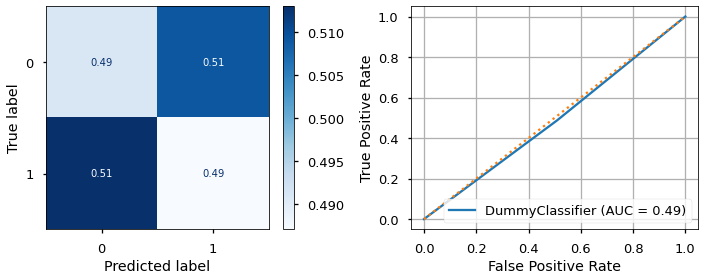

In [106]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_tf_df, y_train)

clf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'accuracy')

---

**Interpretation**

> The baseline model is designed to be a poor-performer: the results, as expected, are close to .5 for most metrics, indicating the model is not performing better than simply guessing one result or the other.
>
> Now I will train more advanced models, using this baseline for comparison against their metrics.

---

#  📊 **Logistic Regression Model**


|-------------------------------- Classification Metrics -----------------------------------|

Training average precision score: 0.64
Testing average precision score: 0.61
	- The training score is larger by 0.03 points.

Training data log loss: 0.63
Testing data log loss: 0.66



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.50      0.56      0.53       666
           1       0.71      0.66      0.68      1082

    accuracy                           0.62      1748
   macro avg       0.61      0.61      0.61      1748
weighted avg       0.63      0.62      0.63      1748



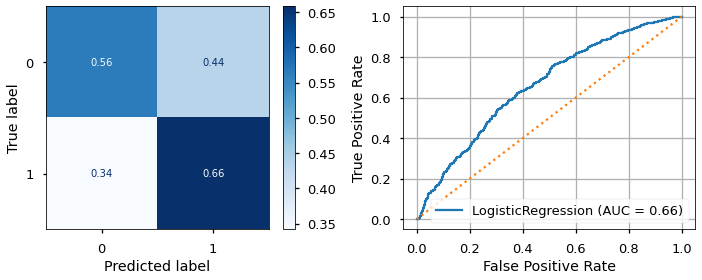

In [135]:
## LogReg Model
logreg = LogisticRegression(max_iter = 500, random_state = 42, n_jobs=-1)

logreg.fit(X_train_tf_df, y_train)

clf.evaluate_classification(logreg, X_train = X_train_tf_df,y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'average precision')

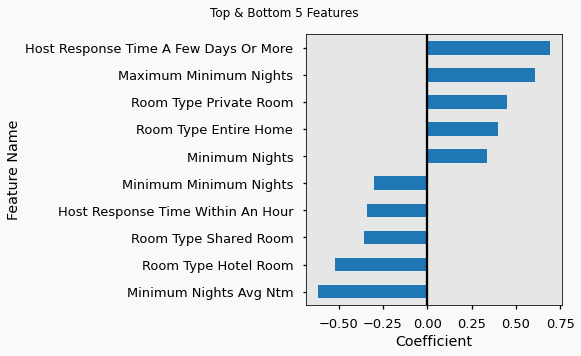

In [137]:
clf.plot_log_odds(logreg, X_test_tf_df, num_feats=5)

---

**Interpretation: Basic Logistic Regression**

> The basic logistic regression performed slightly better than the baseline, with a 60% accuracy score. This score is less than ideal (I would prefer an accuracy score of ,75+), so I will use GridSearchCV to perform hyperparameter tuning.

---


## Logistic Regression GridSearchCV

In [140]:
## Creating dictionary of hyperparameters and values to test
lg_params = {
    'max_iter': [750, 1000, 1250],
    'C': [1, 10],
    'solver': ['lbfgs','newton-cg']
}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=1, max_iter=750, solver=lbfgs .................................
[CV] .................. C=1, max_iter=750, solver=lbfgs, total=   0.2s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] C=1, max_iter=750, solver=lbfgs .................................
[CV] .................. C=1, max_iter=750, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=750, solver=lbfgs .................................
[CV] .................. C=1, max_iter=750, solver=lbfgs, total=   0.1s
[CV] C=1, max_iter=750, solver=lbfgs .................................
[CV] .................. C=1, max_iter=750, solver=lbfgs, total=   0.1s
[CV] C=1, max_iter=750, solver=lbfgs .................................
[CV] .................. C=1, max_iter=750, solver=lbfgs, total=   1.0s
[CV] C=1, max_iter=750, solver=newton-cg .............................
[CV] .............. C=1, max_iter=750, solver=newton-cg, total=   1.1s
[CV] C=1, max_iter=750, solver=newton-cg .............................


The line search algorithm did not converge
Line Search failed


[CV] .............. C=1, max_iter=750, solver=newton-cg, total=   0.8s
[CV] C=1, max_iter=750, solver=newton-cg .............................
[CV] .............. C=1, max_iter=750, solver=newton-cg, total=   1.1s
[CV] C=1, max_iter=750, solver=newton-cg .............................


Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


[CV] .............. C=1, max_iter=750, solver=newton-cg, total=   1.4s
[CV] C=1, max_iter=750, solver=newton-cg .............................


The line search algorithm did not converge
Line Search failed


[CV] .............. C=1, max_iter=750, solver=newton-cg, total=   1.9s
[CV] C=1, max_iter=1000, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1000, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1000, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1000, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1000, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1000, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1000, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1000, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1000, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1000, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1000, solver=newton-cg ............................
[CV] ............. C=1, max_iter=1000, solver=newton-cg, total=   1.6s
[CV] C=1, max_iter=1000, solver=newton-cg ............................


The line search algorithm did not converge
Line Search failed


[CV] ............. C=1, max_iter=1000, solver=newton-cg, total=   1.0s
[CV] C=1, max_iter=1000, solver=newton-cg ............................
[CV] ............. C=1, max_iter=1000, solver=newton-cg, total=   1.6s
[CV] C=1, max_iter=1000, solver=newton-cg ............................


Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


[CV] ............. C=1, max_iter=1000, solver=newton-cg, total=   1.3s
[CV] C=1, max_iter=1000, solver=newton-cg ............................


The line search algorithm did not converge
Line Search failed


[CV] ............. C=1, max_iter=1000, solver=newton-cg, total=   1.9s
[CV] C=1, max_iter=1250, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1250, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1250, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1250, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1250, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1250, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1250, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1250, solver=lbfgs, total=   0.2s
[CV] C=1, max_iter=1250, solver=lbfgs ................................
[CV] ................. C=1, max_iter=1250, solver=lbfgs, total=   0.3s
[CV] C=1, max_iter=1250, solver=newton-cg ............................
[CV] ............. C=1, max_iter=1250, solver=newton-cg, total=   1.2s
[CV] C=1, max_iter=1250, solver=newton-cg ............................


The line search algorithm did not converge
Line Search failed


[CV] ............. C=1, max_iter=1250, solver=newton-cg, total=   1.7s
[CV] C=1, max_iter=1250, solver=newton-cg ............................
[CV] ............. C=1, max_iter=1250, solver=newton-cg, total=   1.7s
[CV] C=1, max_iter=1250, solver=newton-cg ............................


Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


[CV] ............. C=1, max_iter=1250, solver=newton-cg, total=   1.6s
[CV] C=1, max_iter=1250, solver=newton-cg ............................


The line search algorithm did not converge
Line Search failed


[CV] ............. C=1, max_iter=1250, solver=newton-cg, total=   1.9s
[CV] C=10, max_iter=750, solver=lbfgs ................................
[CV] ................. C=10, max_iter=750, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=750, solver=lbfgs ................................
[CV] ................. C=10, max_iter=750, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=750, solver=lbfgs ................................
[CV] ................. C=10, max_iter=750, solver=lbfgs, total=   0.2s
[CV] C=10, max_iter=750, solver=lbfgs ................................
[CV] ................. C=10, max_iter=750, solver=lbfgs, total=   0.2s
[CV] C=10, max_iter=750, solver=lbfgs ................................
[CV] ................. C=10, max_iter=750, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=750, solver=newton-cg ............................


The line search algorithm did not converge
Line Search failed


[CV] ............. C=10, max_iter=750, solver=newton-cg, total=   3.6s
[CV] C=10, max_iter=750, solver=newton-cg ............................
[CV] ............. C=10, max_iter=750, solver=newton-cg, total=   2.2s
[CV] C=10, max_iter=750, solver=newton-cg ............................
[CV] ............. C=10, max_iter=750, solver=newton-cg, total=   2.9s
[CV] C=10, max_iter=750, solver=newton-cg ............................


The line search algorithm did not converge
Line Search failed


[CV] ............. C=10, max_iter=750, solver=newton-cg, total=   2.4s
[CV] C=10, max_iter=750, solver=newton-cg ............................


Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


[CV] ............. C=10, max_iter=750, solver=newton-cg, total=   2.3s
[CV] C=10, max_iter=1000, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1000, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1000, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1000, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1000, solver=lbfgs, total=   0.2s
[CV] C=10, max_iter=1000, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1000, solver=newton-cg ...........................


Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


[CV] ............ C=10, max_iter=1000, solver=newton-cg, total=   3.4s
[CV] C=10, max_iter=1000, solver=newton-cg ...........................
[CV] ............ C=10, max_iter=1000, solver=newton-cg, total=   1.7s
[CV] C=10, max_iter=1000, solver=newton-cg ...........................
[CV] ............ C=10, max_iter=1000, solver=newton-cg, total=   2.1s
[CV] C=10, max_iter=1000, solver=newton-cg ...........................


The line search algorithm did not converge
Line Search failed


[CV] ............ C=10, max_iter=1000, solver=newton-cg, total=   2.6s
[CV] C=10, max_iter=1000, solver=newton-cg ...........................


The line search algorithm did not converge
Line Search failed


[CV] ............ C=10, max_iter=1000, solver=newton-cg, total=   2.9s
[CV] C=10, max_iter=1250, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1250, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1250, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1250, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1250, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1250, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1250, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1250, solver=lbfgs, total=   0.2s
[CV] C=10, max_iter=1250, solver=lbfgs ...............................
[CV] ................ C=10, max_iter=1250, solver=lbfgs, total=   0.3s
[CV] C=10, max_iter=1250, solver=newton-cg ...........................


Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


[CV] ............ C=10, max_iter=1250, solver=newton-cg, total=   3.6s
[CV] C=10, max_iter=1250, solver=newton-cg ...........................
[CV] ............ C=10, max_iter=1250, solver=newton-cg, total=   1.6s
[CV] C=10, max_iter=1250, solver=newton-cg ...........................
[CV] ............ C=10, max_iter=1250, solver=newton-cg, total=   2.1s
[CV] C=10, max_iter=1250, solver=newton-cg ...........................


The line search algorithm did not converge
Line Search failed


[CV] ............ C=10, max_iter=1250, solver=newton-cg, total=   2.4s
[CV] C=10, max_iter=1250, solver=newton-cg ...........................


The line search algorithm did not converge
Line Search failed
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


[CV] ............ C=10, max_iter=1250, solver=newton-cg, total=   2.5s

|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 0.64
Testing accuracy score: 0.61
	- The training score is larger by 0.03 points.

Training data log loss: 0.63
Testing data log loss: 0.66



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.49      0.57      0.53       666
           1       0.71      0.64      0.67      1082

    accuracy                           0.61      1748
   macro avg       0.60      0.60      0.60      1748
weighted avg       0.63      0.61      0.62      1748



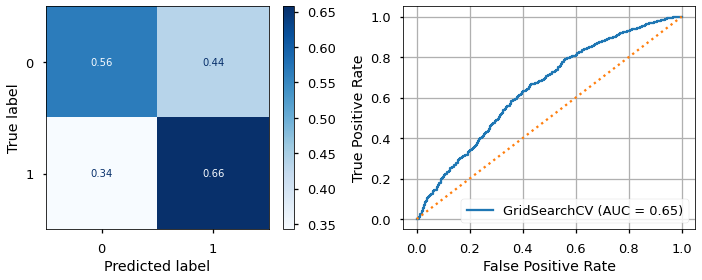

In [141]:
## LogReg-GridSearch Model
lrgs = GridSearchCV(LogisticRegression(random_state = 42, n_jobs = -1), lg_params,
                    scoring = 'average_precision', verbose = 2)

lrgs.fit(X_train_tf_df, y_train)

clf.evaluate_classification(lrgs, X_train = X_train_tf_df,y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test)

In [142]:
## Inspecting best hyperparameters
lrgs.best_params_

{'C': 1, 'max_iter': 1250, 'solver': 'lbfgs'}

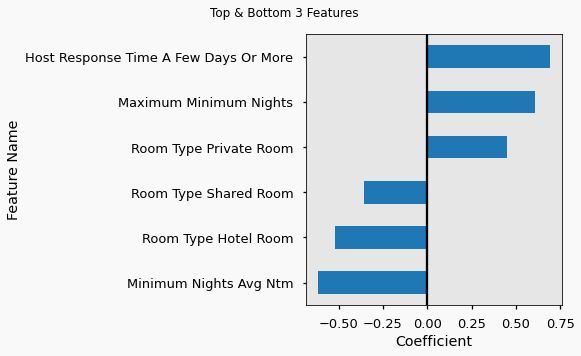

In [115]:
best_logreg = lrgs.best_estimator_

clf.plot_log_odds(best_logreg, X_test_tf_df, num_feats=5)

---

**Interpretation**

> The simple LogReg model shows a slight performance increase - the log-loss decreased, the accuracy incrased, and my macro recall score also increased.
>
> This model mis-predicts values about 64% of the time, most likely due to the class imbalances.

---

# 📊 **RandomForestClassifier**

### Vanilla RFC

In [116]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

In [117]:
rfc.fit(X_train_tf_df, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training accuracy score: 1.0
Testing accuracy score: 0.69
	- The training score is larger by 0.31 points.

Training data log loss: 0.66
Testing data log loss: 0.76



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.63      0.45      0.53       666
           1       0.71      0.83      0.77      1082

    accuracy                           0.69      1748
   macro avg       0.67      0.64      0.65      1748
weighted avg       0.68      0.69      0.68      1748



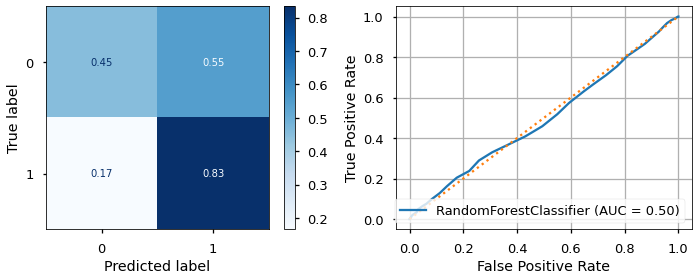

In [118]:
clf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'accuracy')

## RFC GSCV

In [119]:
rfc_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [40,50, 60],
              'min_samples_split': [2,3]
}

rfgs = GridSearchCV(RandomForestClassifier(random_state = 42, n_jobs=-1),
                    rfc_params,scoring = 'average_precision',verbose = 1,
                   cv = 3)

rfgs.fit(X_train_tf_df, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] criterion=gini, max_depth=40, min_samples_split=2 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=40, min_samples_split=2, total=   0.2s
[CV] criterion=gini, max_depth=40, min_samples_split=2 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=40, min_samples_split=2, total=   0.2s
[CV] criterion=gini, max_depth=40, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=40, min_samples_split=2, total=   0.2s
[CV] criterion=gini, max_depth=40, min_samples_split=3 ...............
[CV]  criterion=gini, max_depth=40, min_samples_split=3, total=   0.2s
[CV] criterion=gini, max_depth=40, min_samples_split=3 ...............
[CV]  criterion=gini, max_depth=40, min_samples_split=3, total=   0.2s
[CV] criterion=gini, max_depth=40, min_samples_split=3 ...............
[CV]  criterion=gini, max_depth=40, min_samples_split=3, total=   0.2s
[CV] criterion=gini, max_depth=50, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=50, min_samples_split=2, total=   0.2s
[CV] criterion=gini, max_depth=50, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=50, min_samples_split=2, total=   0.2s
[CV] criterion=gini, max_depth=50, min_samples_split=2 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   16.5s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [40, 50, 60],
                         'min_samples_split': [2, 3]},
             scoring='average_precision', verbose=2)

In [120]:
rfgs.best_params_

{'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 3}

In [121]:
best_rfc = rfgs.best_estimator_


|-------------------------------- Classification Metrics -----------------------------------|

Training average precision score: 1.0
Testing average precision score: 0.67
	- The training score is larger by 0.33 points.

Training data log loss: 0.16
Testing data log loss: 0.62



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       666
           1       0.71      0.84      0.77      1082

    accuracy                           0.69      1748
   macro avg       0.67      0.65      0.65      1748
weighted avg       0.68      0.69      0.68      1748



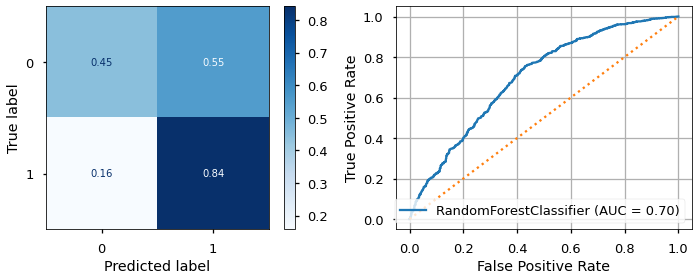

In [122]:
clf.evaluate_classification(best_rfc, X_train = X_train_tf_df,y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'average precision')

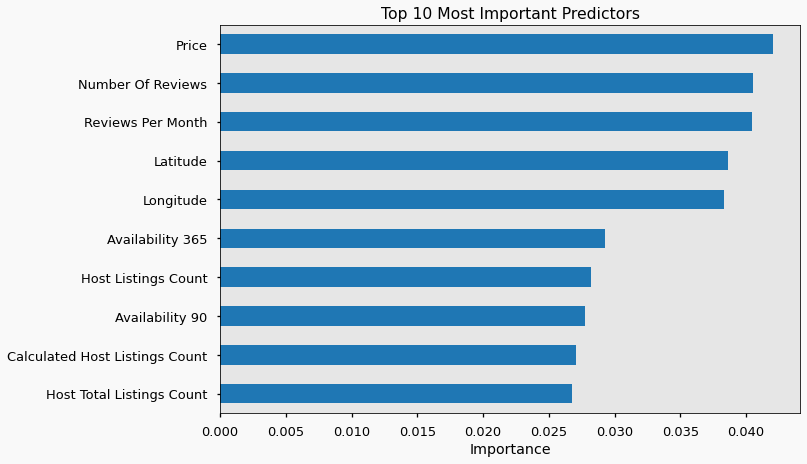

In [123]:
## New Importances
clf.plot_importances(best_rfc, X_test_tf_df)

---

**Interpreting Results**

> My resulting feature importances show that **the strongest predictor of scores 4.8+ would be whether or not a host is a SuperHost.** This makes sense, as one of the requirements for a host to be a SuperHost is to maintain a 4.8+ score, in addition to other requirements.
>
> Following SuperHost status are the number of listings for a host. **If a host has a large number of properties, they would most likely be an established businessperson and would be committed to hospitality, versus someone just renting out a spare room.**

---

# **Interpreting Results with SHAP**

---

> **One of the downsides of tree-based models is the difficulty when interpreting the impact of a specific feature.** Feature importances from tree-based models indicate how often a feature was used to make a decision, but they do not indicate if that feature was more or less likely to predict the target feature.
>
> To interpret these results, I will utilize a visualization package called **SHAP** to produce "Shapely values" for each feature. These values indicate each feature's marginal contribution to the model - answering the question, "*How well does the model perform with this feature than without?*"
>
>Using tools within the package, I will focus on the `summary_plot`, which visualizes each feature's Shapely value and the feature's  specific values from low-high (relative to each feature).
>
> More information about SHAP:
* [SHAP Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
* [SHAP Repository](https://github.com/slundberg/shap)

---

In [124]:
 ## Initializing Javascript for SHAP models
shap.initjs()

In [125]:
## Generating a sample of the overall data for review:
X_shap = shap.sample(X_test_tf_df, nsamples=50)

In [126]:
## Initializing an explainer with the RandomForestClassifier model
t_explainer = shap.TreeExplainer(rfgs.best_estimator_)

## Using TreeExplainer

---

> The SHAP package includes a few different "Explainer" objects to "explain" the results of different types of models. Since I used a RandomForestClassifier, I will use the "TreeExplainer" to calculate my SHAP values for plotting.

---

In [127]:
## Calculating SHAP values for sample test data
shap_values = t_explainer.shap_values(X_shap)
len(shap_values)

2

In [128]:
## Preparing column names for visualization labels
X_shap.rename(columns = lambda x: x.title().replace('_', ' '), inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


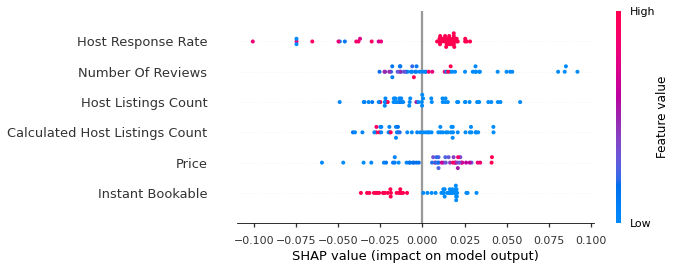

In [144]:
## Better plot
shap.summary_plot(shap_values[1],X_shap,max_display=6)

# 💡 **Final Recommendations**


---

> **Based on the results of my models, I would recommend for Airbnb to prioritize promoting hosts to SuperHost status.**  SuperHost status is the strongest predictor for the desired high scores, and it is realistic for Airbnb to invest in their development and support. The second- and third-strongest predictors are much more difficult (and unrealistic) for Airbnb and hosts to improve.
>
> For further development, I would do the following:
>* **Include details from text reviews:** while the traditional survey questions are respected and informative, text-based reviews take precedence. In my experience in hotel operations, I would often get much more information from the written reviews, including nuances and specifics that the yes/no or 1-5 ratings miss.
>* **Include other regions:** My current dataset focused only on the Washington, D.C. area. Due to different regional factors (social/economic demographics; legal restrictions; etc.), other markets may show other features to be more important than my results. Additionally, I would like to explore international data to compare with the domestic data.

--- 